Andrew Frazier  
28 February, 2021  
Data 110.DS1  

Midterm 1

#### Table of Contents
1. [Import and Initial Expection](#import)
2. [Visualizations](#viz)
    * 2.1 [Univariate](#univiz)
    * 2.2 [Multivariate](#multiviz)
3. [Data Cleaning](#clean)
    * 3.1 [Dummy Encode](#dummy_encode)
    * 3.2 [Standard Scale](#scale)
    * 3.3 [Rebalance](#balance)
4. [Cross Validation](#cross_Val) 
5. [Modeling](#models)
    * 5.1 [Extra Trees](#xtrees)
    * 5.2 [Random Forest](#forest)
    * 5.3 [Gradient Boost](#gradboost)
3. [Conclusion](#fin)

<a id='import'></a>

# Import and Initial Inspection

In [134]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [135]:
df = pd.read_csv('bank.csv', delimiter=';', engine='python')
df = df.drop(columns='duration') # Per data dictionary

In [136]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,1,-1,0,unknown,no


In [137]:
df.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,2,249,7,other,no


In [138]:
print(df.shape)

(4521, 16)


*Dataset contains 4,521 observations across 16 columns*

In [139]:
#check for missing values
df.isnull().values.any()

False

*No missing/NAN values exist*

In [140]:
#Check for duplicates
duplicates =  df[df.duplicated(keep=False)]
print(duplicates.shape)

(0, 16)


*No Duplicate values exist*

In [141]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

I'm going to rename some columns in the interest of quicker comprehension, and less referencing of data dictionary. 

In [142]:
#Column Rename
custom_columns = ['age','job','marital_status','education','credit_default','bank_balance','house_loan','personal_loan','contact','dayofmonth','month_contacted','campaign_contacts','pdays','previous','p_outcome','deposit']
df.columns = custom_columns

<a id='viz'></a>

# Data Visualizations

<a id='univiz'></a>

### Univariate

In [143]:
df.describe()

,age,bank_balance,dayofmonth,campaign_contacts,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,50.000000,871.000000,25.000000


The Average Age is 41, with a standard deviation of 10.6. I'll add another column with bins for easier visualization. 

The average Bank balance is 1,422EU, but the very high standard deviation along with the different in min/max values show us this is distributed across a wide range. Inspite of this evidence of outliers, I don't think it makes sense to remove any, in the context of building a model.

'Dayofmonth' mean tell us that most contacts occurred in the middle of the month.

The average number of contacts in a campaign is 2.8 with a standard deviation of 3.1.

'pdays' presents a potential problem. The data dictionary noted that any pday of 999 means a client hasn't been previously contacted. it doesn't say anything about a value of -1, which looks to dominate most of the observations in this column. Our pday max is 871, so all data represents previously contacted individuals.

'previous' indicates a mean contact per client of 0.5, with a standard deviation of 1.7. Compared to 'campaign_contacts' we know that average contact activity has increased. 

In [144]:
cat_data = df.select_dtypes(exclude='number')
cat_data

,job,marital_status,education,credit_default,house_loan,personal_loan,contact,month_contacted,p_outcome,deposit
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no
...,...,...,...,...,...,...,...,...,...,...
4516,services,married,secondary,no,yes,no,cellular,jul,unknown,no
4517,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown,no
4518,technician,married,secondary,no,no,no,cellular,aug,unknown,no
4519,blue-collar,married,secondary,no,no,no,cellular,feb,other,no


First I'll look at socio-economic categories(age, job, marriage status, education, credit default, house loan, personal loan, contact), then we'll look at categories related to the campaign activities(month_contacted, p_outcome, deposit)

The most individuals in the dataset are between 30-25  years old. We also see a sharp drop off in data after 60 years old. 

In [145]:
n = cat_data.nunique(axis=0) 
  
print("Levels within Categorical Values :\n", 
      n)

Levels within Categorical Values :
 job                12
marital_status      3
education           4
credit_default      2
house_loan          2
personal_loan       2
contact             3
month_contacted    12
p_outcome           4
deposit             2
dtype: int64


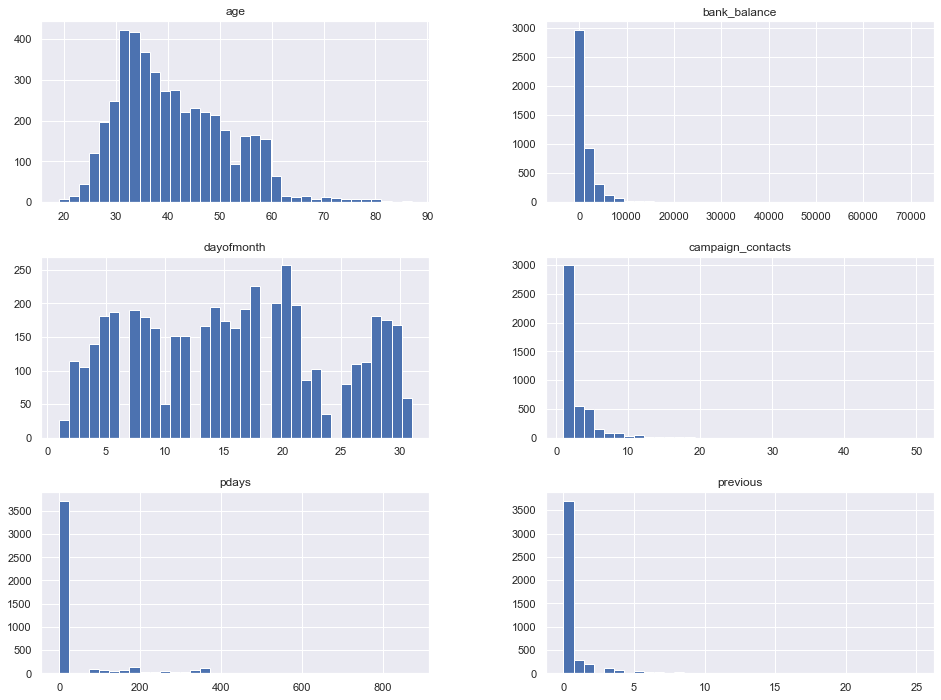

In [146]:
df.hist(bins=35, figsize=(16,12))
plt.show()

In [147]:
#add bins to age for viz
bins = [10,20,30,40,50,60,70,80,90]
labels = ['10-19','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']
df['age_range'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

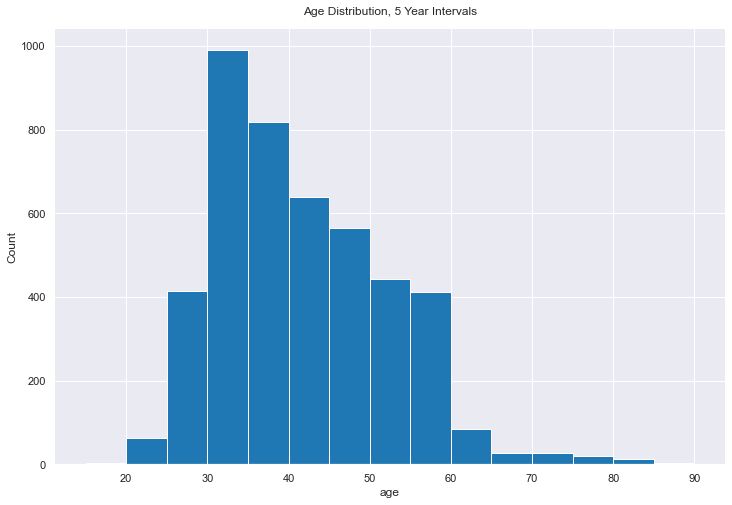

In [148]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 8))

sns.histplot(data=df, x='age', binwidth=5, binrange=(15,90), color='tab:blue', alpha=1)
plt.title("Age Distribution, 5 Year Intervals", y = 1.02)

sns.despine(left=True)
plt.show()

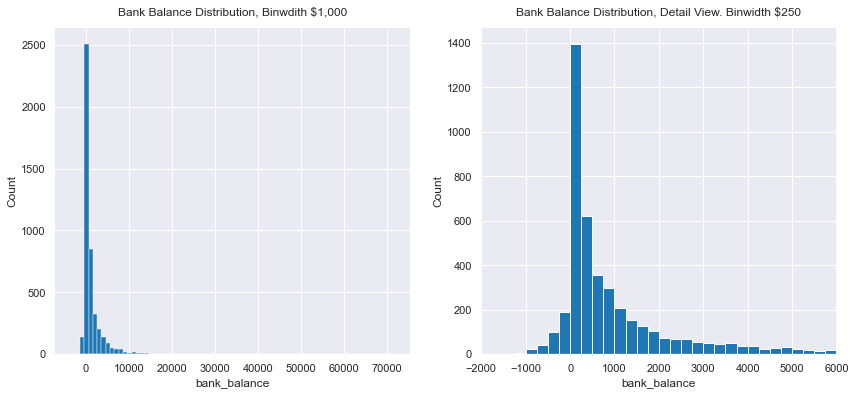

In [149]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='bank_balance', binwidth=1000, color='tab:blue', alpha=1)
plt.title("Bank Balance Distribution, Binwdith $1,000", y = 1.02)

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='bank_balance', binwidth=250,binrange=(-2000,6000), color='tab:blue', alpha=1)
plt.title("Bank Balance Distribution, Detail View. Binwidth $250", y = 1.02)
plt.xlim(-2000,6000)

sns.despine(left=True)
plt.show()

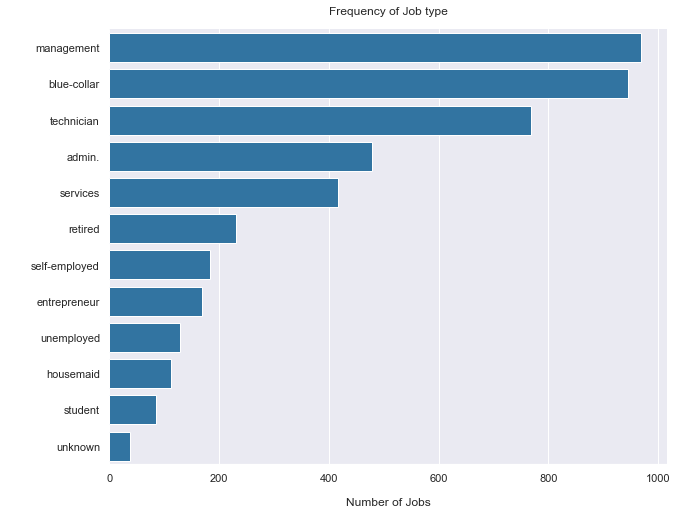

In [150]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

sns.countplot(y='job', data=df, order=df['job'].value_counts().index, color='tab:blue')
plt.xlabel("Number of Jobs", labelpad=14)
plt.ylabel(" ", labelpad=14)
plt.title("Frequency of Job type", y = 1.02)

sns.despine(left=True)
plt.show()

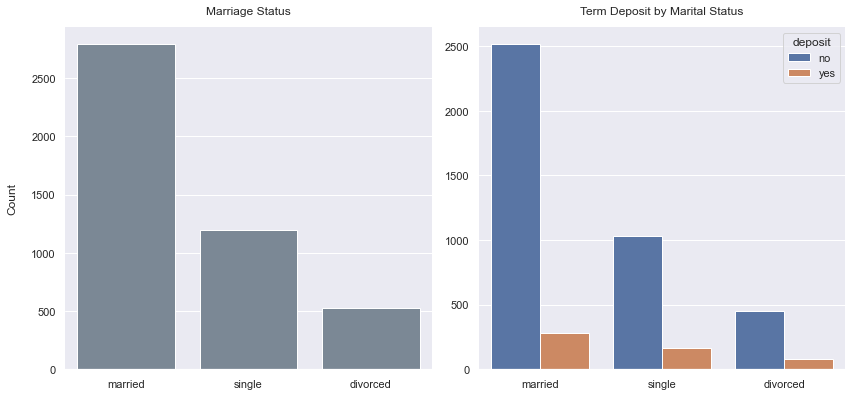

In [151]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='marital_status', data=df, order=df['marital_status'].value_counts().index, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Marriage Status", y = 1.02)

plt.subplot(1, 2, 2)
sns.countplot(x='marital_status', data=df, order=df['marital_status'].value_counts().index, hue='deposit')
plt.xlabel(" ", labelpad=14)
plt.ylabel("", labelpad=14)
plt.title("Term Deposit by Marital Status", y = 1.02)

sns.despine(left=True)
plt.tight_layout()
plt.show()

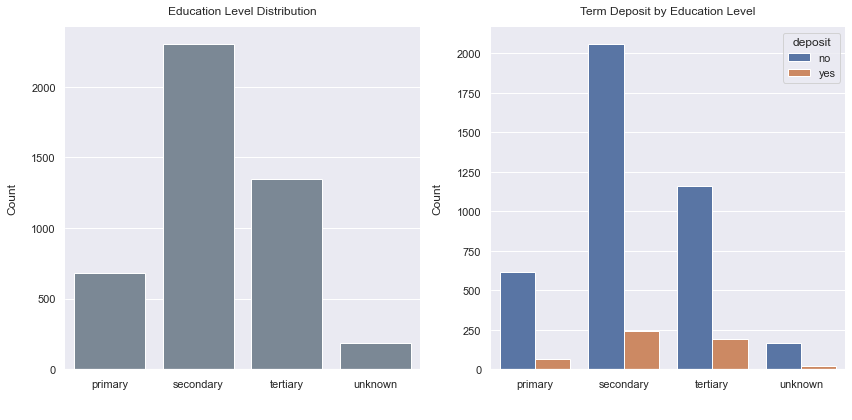

In [152]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='education', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Education Level Distribution", y = 1.02)

plt.subplot(1, 2, 2)
sns.countplot(x='education', data=df, hue='deposit')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Term Deposit by Education Level", y = 1.02)

sns.despine(left=True)
plt.tight_layout()
plt.show()

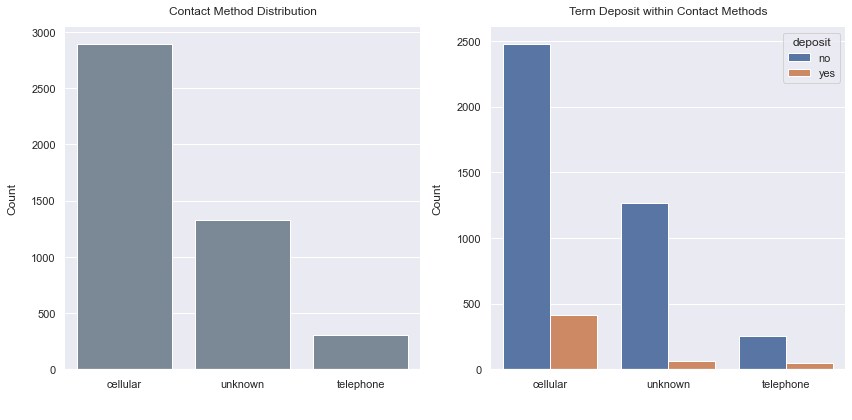

In [153]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='contact', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Contact Method Distribution", y = 1.02)

plt.subplot(1, 2, 2)
sns.countplot(x='contact', data=df, hue='deposit')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Term Deposit within Contact Methods", y = 1.02)

sns.despine(left=True)
plt.tight_layout()
plt.show()

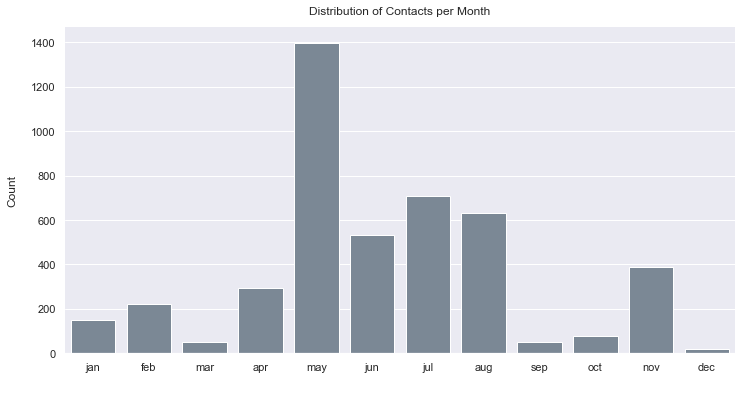

In [154]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

sns.countplot(x='month_contacted', data=df, color='lightslategrey', order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of Contacts per Month", y = 1.02)

sns.despine(left=True)
plt.show()

Summer months have a noticeably large rate of contact that the rest of the year

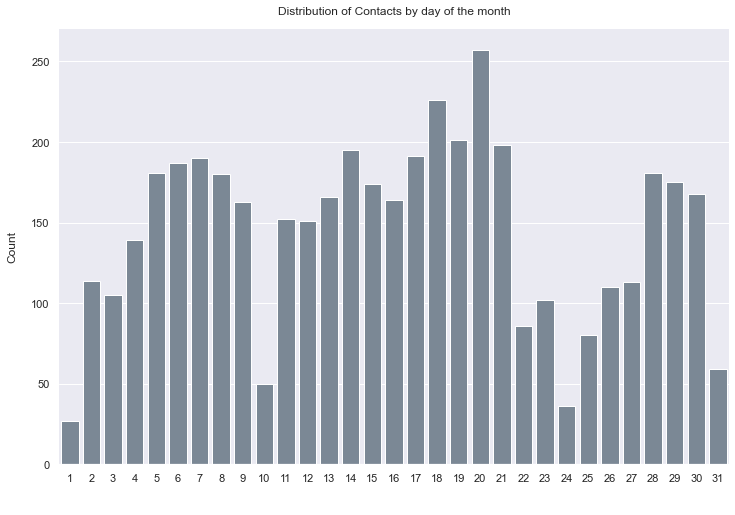

In [155]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 8))

sns.countplot(x='dayofmonth', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of Contacts by day of the month", y = 1.02)

sns.despine(left=True)
plt.show()

We won't see 100% accuracy here because of the variation in month lengths

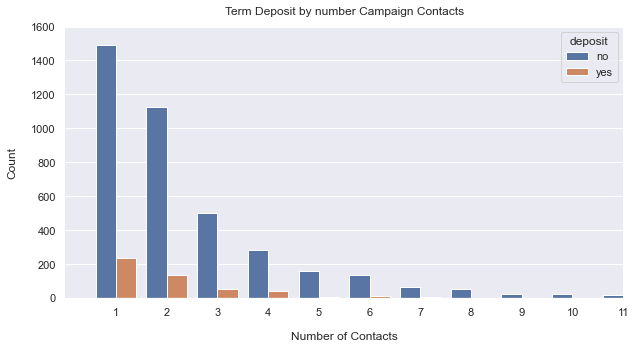

In [156]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))

sns.countplot(x='campaign_contacts', data=df, hue='deposit')
plt.xlabel("Number of Contacts", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Term Deposit by number Campaign Contacts", y = 1.02)
plt.xlim(-1,10)
plt.ylim(0,1600)

sns.despine(left=True)
plt.show()

Campaign contacts falls off pretty dramatically. Contacting more times doesn't appear to meaningfully increase term deposits, i.e. proportion of Yes/No appears relatively equal as contacts decrease. 

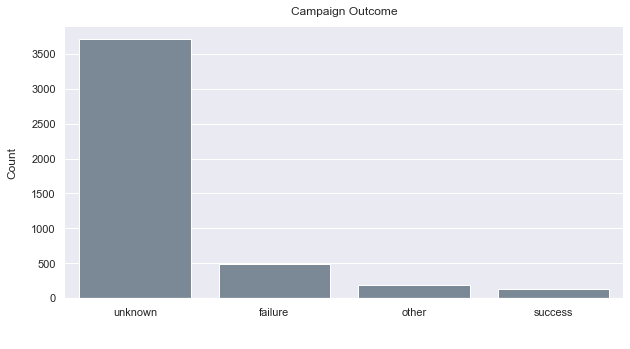

In [157]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))

sns.countplot(x='p_outcome', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Campaign Outcome", y = 1.02)

sns.despine(left=True)
plt.show()

Very little data available on the outcome effectiveness of the campaign

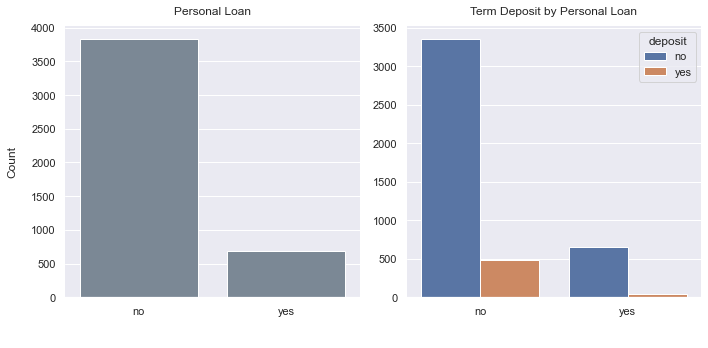

In [158]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='personal_loan', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Personal Loan", y = 1.02)

plt.subplot(1, 2, 2)
sns.countplot(x='personal_loan', data=df, hue='deposit')
plt.xlabel(" ", labelpad=14)
plt.ylabel("", labelpad=14)
plt.title("Term Deposit by Personal Loan", y = 1.02)

sns.despine(left=True)
plt.tight_layout()
plt.show()

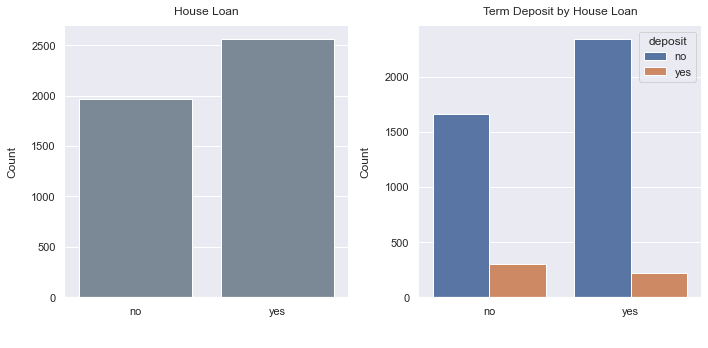

In [159]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='house_loan', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("House Loan", y = 1.02)

plt.subplot(1, 2, 2)
sns.countplot(x='house_loan', data=df, hue='deposit')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Term Deposit by House Loan", y = 1.02)

sns.despine(left=True)
plt.tight_layout()
plt.show()

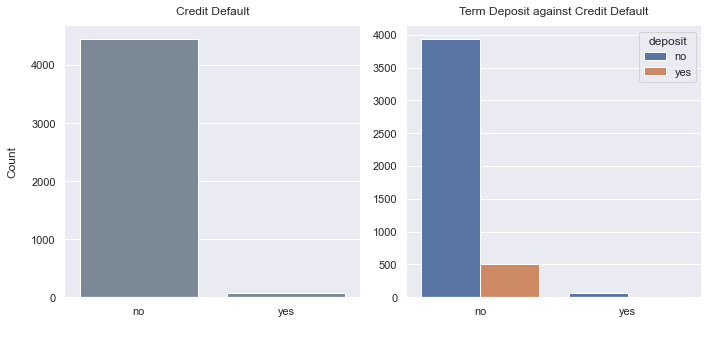

In [160]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='credit_default', data=df, color='lightslategrey')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Credit Default", y = 1.02)

plt.subplot(1, 2, 2)
sns.countplot(x='credit_default', data=df,hue='deposit')
plt.xlabel(" ", labelpad=14)
plt.ylabel("", labelpad=14)
plt.title("Term Deposit against Credit Default", y = 1.02)

sns.despine(left=True)
plt.tight_layout()
plt.show()

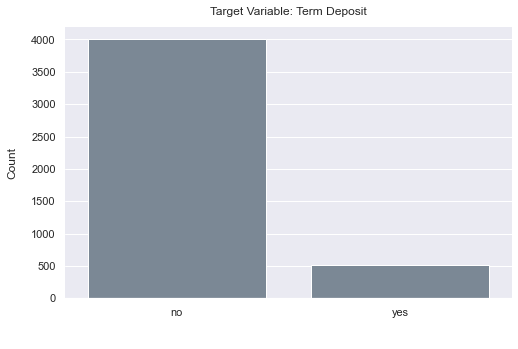

In [161]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 5))

sns.countplot(x='deposit', data=df, color='lightslategray')
plt.xlabel(" ", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Target Variable: Term Deposit", y = 1.02)

sns.despine(left=True)
plt.show()

There is a large imbalance in the target variable that will require rebalancing for better model results

<a id='multiviz'></a>

### Multivariate

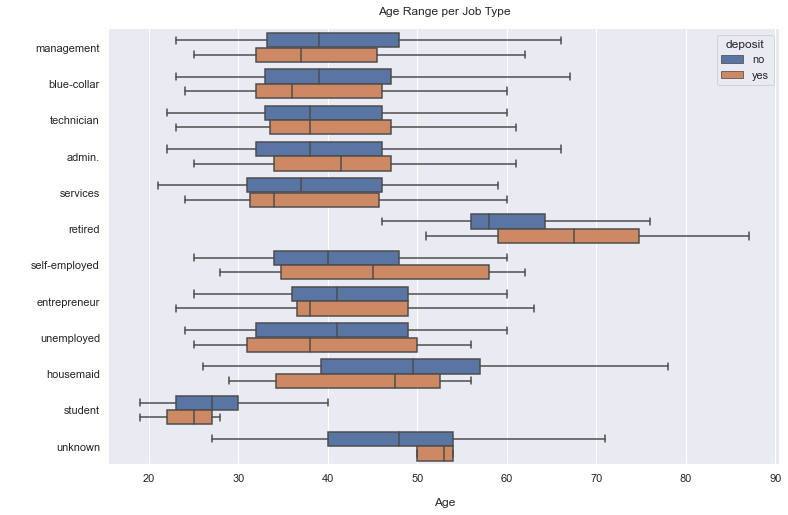

In [162]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

sns.boxplot(y='job', x='age', data=df, order=df['job'].value_counts().index, hue='deposit', showfliers = False)
plt.xlabel("Age", labelpad=14)
plt.ylabel(" ", labelpad=14)
plt.title("Age Range per Job Type", y = 1.02)

sns.despine(left=True)
plt.show()

Student and retired ages are predictable. Housemaid has median ages higher than other job types, which may speak to cultural/socio-economic factors. We can clearly see that the average working age in the dataset is late 30's to early 40's. 

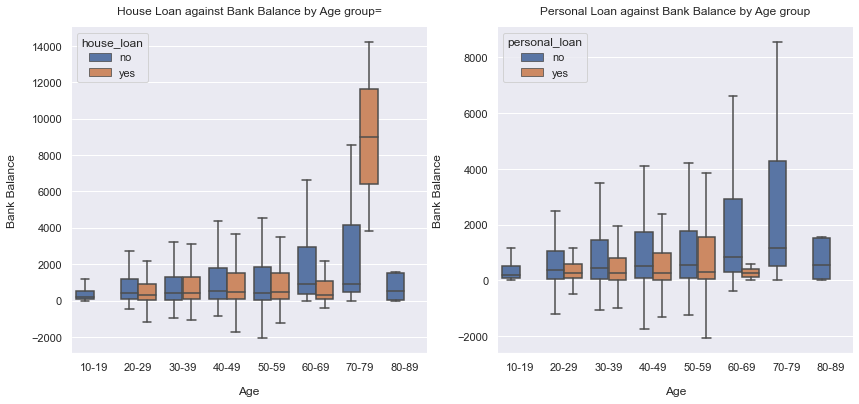

In [170]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)

plt.subplot(1, 2, 1)
sns.boxplot(data=df,x='age_range', y='bank_balance', hue='house_loan', showfliers = False)
plt.xlabel("Age", labelpad=14)
plt.ylabel("Bank Balance", labelpad=14)
plt.title("House Loan against Bank Balance by Age group=", y = 1.02)

plt.subplot(1, 2, 2)
sns.boxplot(data=df,x='age_range', y='bank_balance', hue='personal_loan', showfliers = False)
plt.xlabel("Age", labelpad=14)
plt.ylabel("Bank Balance", labelpad=14)
plt.title("Personal Loan against Bank Balance by Age group", y = 1.02)

sns.despine(left=True)
plt.show()

A small association exists between lower bank balance and having a house/personal loan. At the ages of 70-79 bank balance max skyrockets, suggesting relatively few datapoints in this group, among which have high bank balances. 

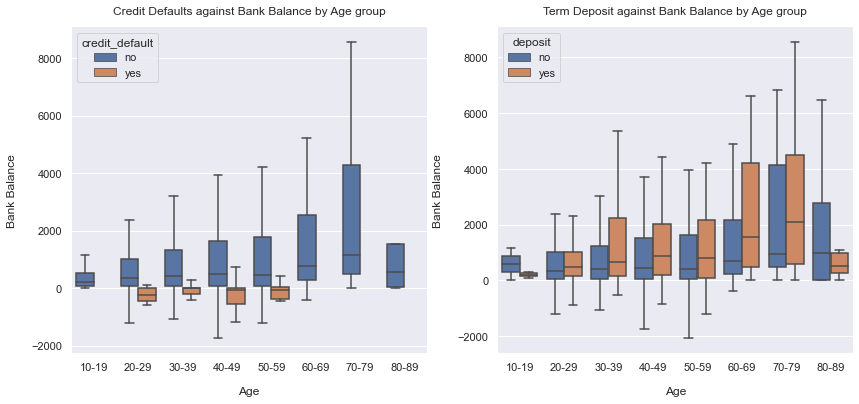

In [173]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)

plt.subplot(1, 2, 1)
sns.boxplot(data=df,x='age_range', y='bank_balance', hue='credit_default', showfliers = False)
plt.xlabel("Age", labelpad=14)
plt.ylabel("Bank Balance", labelpad=14)
plt.title("Credit Defaults against Bank Balance by Age group", y = 1.02)

plt.subplot(1, 2, 2)
sns.boxplot(data=df,x='age_range', y='bank_balance', hue='deposit', showfliers = False)
plt.xlabel("Age", labelpad=14)
plt.ylabel("Bank Balance", labelpad=14)
plt.title("Term Deposit against Bank Balance by Age group", y = 1.02)

sns.despine(left=True)
plt.show()

People with less money in the bank are more much likely to have a credit_default. Interestingly, no clear association exists for term deposit and age range or bank balance. 

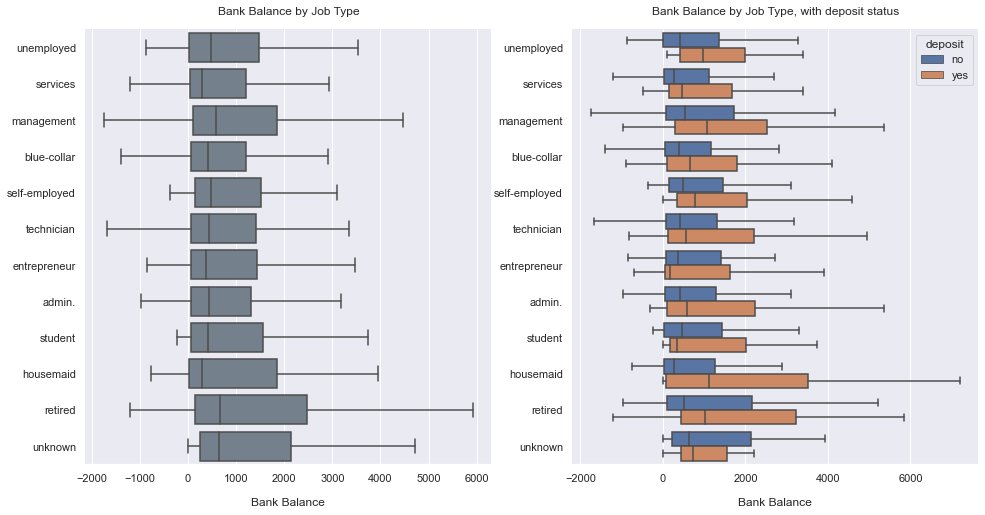

In [175]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

plt.subplot(1, 2, 1)
sns.boxplot(data=df,y='job', x='bank_balance', color='slategrey', showfliers = False)
plt.xlabel("Bank Balance", labelpad=14)
plt.ylabel("", labelpad=14)
plt.title("Bank Balance by Job Type", y = 1.02)

plt.subplot(1, 2, 2)
sns.boxplot(data=df,y='job', x='bank_balance', hue='deposit', showfliers = False)
plt.xlabel("Bank Balance", labelpad=14)
plt.ylabel("", labelpad=14)
plt.title("Bank Balance by Job Type, with deposit status", y = 1.02)

sns.despine(left=True)
plt.show()

Median Job Type remains relatively static among different job types. Min/Max's do vary quite a bit as expected(Management has a max much higher than blue-collar, etc). Adding our target variable doesn't reveal any obvious associations.

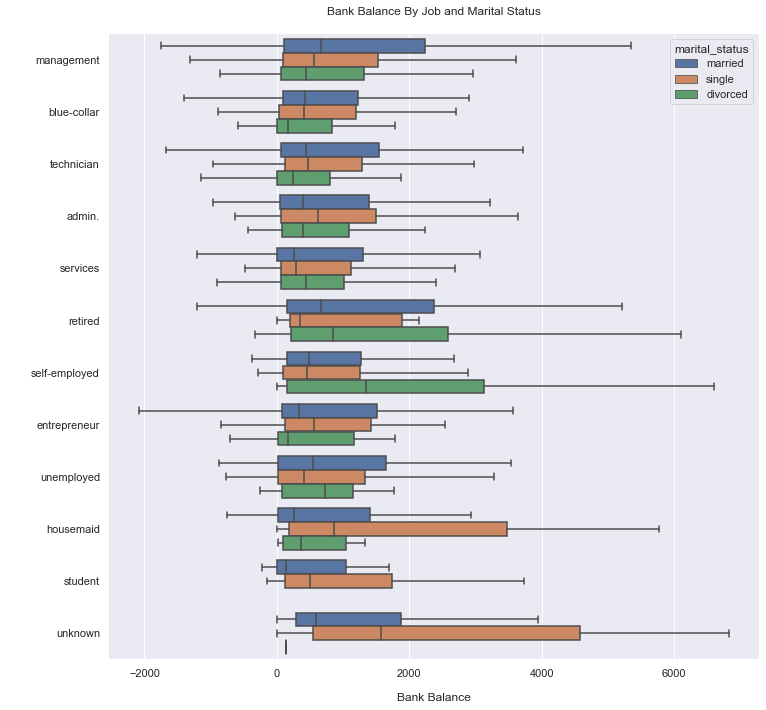

In [176]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 2)
sns.boxplot(y='job', x='bank_balance', data=df, hue='marital_status', order=df['job'].value_counts().index, showfliers = False)
plt.xlabel("Bank Balance", labelpad=14)
plt.ylabel(" ", labelpad=14)
plt.title("Bank Balance By Job and Marital Status", y = 1.02)


sns.despine(left=True)
plt.tight_layout()
plt.show()

The different associations between marriage status, job type, and bank balance are quite interesting. For example, within the house maids category, single people have the highest savings. When we look at the self employed category however, divorced individuals have the most in savings.  
In most job types, married individuals have a wider min/max range than other marital statuses.   
As expected, students have less money in savings, while retired have more. 

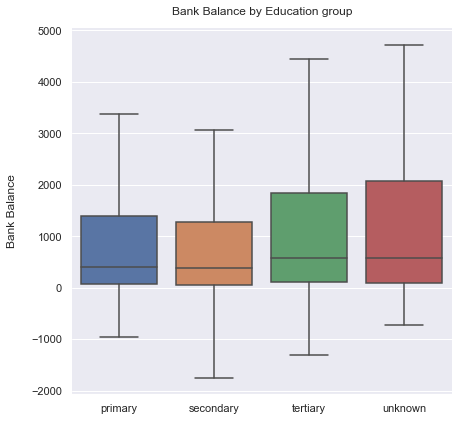

In [183]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

plt.subplot(1, 2, 1)
sns.boxplot(data=df,x='education', y='bank_balance', showfliers = False)
plt.xlabel("", labelpad=14)
plt.ylabel("Bank Balance", labelpad=14)
plt.title("Bank Balance by Education group", y = 1.02)

plt.tight_layout()
sns.despine(left=True)
plt.show()

Higher Education does results in a greater cap on salary, with a slight increase in median. 

<a id='clean'></a>

# Data Cleaning

In [132]:
#Viz Cleanup
df = df.drop(columns=['age_range'])
del(ax, bins, cat_data, custom_columns, duplicates, fig, labels, rcParams)

In [37]:
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, RobustScaler


from sklearn import  model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import RocCurveDisplay

from sklearn.compose import make_column_transformer

<a id='dummy_encode'></a>

### Dummy Encode

In [38]:
np.random.seed(79)
#Dummy Encode
df2 = pd.get_dummies(df, drop_first=True)
df2.head(2)

,age,bank_balance,dayofmonth,campaign_contacts,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_contacted_jun,month_contacted_mar,month_contacted_may,month_contacted_nov,month_contacted_oct,month_contacted_sep,p_outcome_other,p_outcome_success,p_outcome_unknown,deposit_yes
0,30,1787,19,1,-1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,33,4789,11,1,339,4,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
x = df2.drop(columns=['deposit_yes'])
y = df2.deposit_yes

I'm choosing to leave all features in the dataset, in hopes that more data results in a better model. This does leave us in danger of overfitting due to noise, but several of the models I ended up choosing mititage this problem. 

In [40]:
print(x.shape)
print(y.shape)

(4521, 41)
(4521,)


<a id='scale'></a>

### Standard Scale

In [41]:
trans = StandardScaler()

x2 = trans.fit_transform(x)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=79, shuffle=True)

print('Training Shapes:')
print(x_train.shape) 
print(y_train.shape)
print('\nTesting Shapes:')
print(x_test.shape)
print(y_test.shape)

Training Shapes:
(3616, 41)
(3616,)

Testing Shapes:
(905, 41)
(905,)


In [43]:
# Models
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid,RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier,StackingClassifier

# Scoring tools
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score,recall_score,precision_score,f1_score, roc_curve, auc, roc_auc_score
from sklearn.datasets import make_classification

# Utility
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier


<a id='balance'></a>

### Rebalance

In [44]:
 print("Shape of Target Class '1' before oversampling: {}".format(sum(y_train == 1))) 
print("Shape of Target Class '0' before oversampling: {}".format(sum(y_train == 0))) 

Shape of Target Class '1' before oversampling: 418
Shape of Target Class '0' before oversampling: 3198


The objective is to identify activities that lead to deposit = 'yes' or 1. We can see that the imbalance between 0 and 1 is very large. This needs to be rebalanced so that the models have balanced data to work with. If we put in bad data we'll get bad data; rebalancing helps mitigate that obstacle.

Our options are undersampling and/or oversampling. SMOTE seems to be the best course of action here because it gives us a larger pool of data to feed our models, but it's worth noting that documentation suggests random undersampling the majority class before we do this for best results. 

In [45]:
# Pre-Rebalance Model Scoring
extrees = ExtraTreesClassifier(random_state=79) 
extrees.fit(x_train, y_train) 
y_predict = extrees.predict(x_test) 

# print classification report 
accuracy_scoring = round(accuracy_score(y_test, y_predict), 3)
precision_scoring = round(precision_score(y_test, y_predict),3)
recall_scoring = round(recall_score(y_test, y_predict), 3)
f1_scoring = round(f1_score(y_test, y_predict), 3)
roc_auc_scoring = round(roc_auc_score(y_test, y_predict), 3)

print(f'Accuracy: {accuracy_scoring}\n'  f'Precision: {precision_scoring}\n'
      f'Recall score: {recall_scoring}\n'  f'F1 score: {f1_scoring}\n' f'ROC AUC score: {roc_auc_scoring}')

Accuracy: 0.878
Precision: 0.429
Recall score: 0.204
F1 score: 0.276
ROC AUC score: 0.584


#### Undersample

In [46]:
#Random Undersample
undersample = RandomUnderSampler(sampling_strategy=0.35, random_state=79)
x_train, y_train = undersample.fit_resample(x_train, y_train.ravel())

#### SMOTE: Oversample

In [47]:
# Standard SMOTE, Random Oversample
sm = SMOTE(random_state=79)
x_train, y_train = sm.fit_resample(x_train, y_train.ravel())

In [48]:
print('X-training shape after oversampling: {}'.format(x_train.shape)) 
print('Y-training shape after oversampling: {} \n'.format(y_train.shape))  
print("Shape of Target Class '1' before oversampling: {}".format(sum(y_train == 1))) 
print("Shape of Target Class '0' before oversampling: {}".format(sum(y_train == 0))) 

X-training shape after oversampling: (2388, 41)
Y-training shape after oversampling: (2388,) 

Shape of Target Class '1' before oversampling: 1194
Shape of Target Class '0' before oversampling: 1194


Our majority and minority groups have now been balanced. Lets look at some scoring to see how it affects model performance. 

In [49]:
extrees = ExtraTreesClassifier(random_state=79) 
extrees.fit(x_train, y_train) 
y_predict = extrees.predict(x_test) 

# print classification report 
accuracy_scoring = round(accuracy_score(y_test, y_predict), 3)
precision_scoring = round(precision_score(y_test, y_predict),3)
recall_scoring = round(recall_score(y_test, y_predict), 3)
f1_scoring = round(f1_score(y_test, y_predict), 3)
roc_auc_scoring = round(roc_auc_score(y_test, y_predict), 3)

print(f'Accuracy: {accuracy_scoring}\n'  f'Precision: {precision_scoring}\n'
      f'Recall score: {recall_scoring}\n'  f'F1 score: {f1_scoring}\n' f'ROC AUC score: {roc_auc_scoring}')

Accuracy: 0.809
Precision: 0.26
Recall score: 0.369
F1 score: 0.305
ROC AUC score: 0.617


Accuracy and Precision took a big hit, but our recall, F1 and ROC-AUC all increased. This means that the combination of undersampling then oversampling gives our models better ability to predict deposit=yes, which is our primary goal. 

<a id='cross_Val'></a>

# Cross-Validation

In [50]:
models = []

# Linear Models
models.append(('Linear: Ridge', RidgeClassifier()))
models.append(('Linear: SGD', SGDClassifier()))
models.append(('Linear: Logistic', LogisticRegression()))

# SVM Machines
models.append(('SVM: SVC', SVC()))
models.append(('SVM: NuSVC', NuSVC()))
models.append(('SVM: LinearSVC', LinearSVC()))

# Nearest Neighbor
models.append(('KNN: Neighbor', KNeighborsClassifier()))
models.append(('KNN: Centroid', NearestCentroid()))
models.append(('KNN: Radius Neighbor', RadiusNeighborsClassifier()))

# Decision Tree
models.append(('Tree: Decision Tree', DecisionTreeClassifier()))
models.append(('Tree: Extra Tree', ExtraTreeClassifier()))

#Ensemble
models.append(('Ensemble: ADA Boost', AdaBoostClassifier()))
models.append(('Ensemble: Bagging', BaggingClassifier()))
models.append(('Ensemble: Extra Trees', ExtraTreesClassifier()))
models.append(('Ensemble: Gradient Boost', GradientBoostingClassifier()))
models.append(('Ensemble: Random Trees', RandomForestClassifier()))


results = []
names = []
scoring = 'accuracy'

for name, model in models:
         kfold = model_selection.KFold(n_splits=10, random_state=79, shuffle=True)
         cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
         results.append(cv_results)
         names.append(name)
         msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
         print(msg)

Linear: Ridge: 0.659544 (0.020890)
Linear: SGD: 0.621017 (0.016751)
Linear: Logistic: 0.661638 (0.018465)
SVM: SVC: 0.745408 (0.025021)
SVM: NuSVC: 0.788531 (0.025226)
SVM: LinearSVC: 0.659126 (0.020558)
KNN: Neighbor: 0.752922 (0.025084)
KNN: Centroid: 0.649096 (0.022582)
KNN: Radius Neighbor: nan (nan)
Tree: Decision Tree: 0.757519 (0.017381)
Tree: Extra Tree: 0.786861 (0.023546)
Ensemble: ADA Boost: 0.794380 (0.026646)
Ensemble: Bagging: 0.816569 (0.012871)
Ensemble: Extra Trees: 0.875200 (0.016812)
Ensemble: Gradient Boost: 0.832923 (0.017560)
Ensemble: Random Trees: 0.861397 (0.013876)


Linear Models perform worst, which isn't terribly surprising considering the complexity of the dataset.

SVM Models produce ok results, but they don't perform as well as other models. They also took longer to complete than other model types. 

KNearestNeighbor don't show signs of promise. 

Decision Tree's performed marginally better then the other models so far, but still didn't outperform Ensemble Models.

Ensmble Models performed best on average, both in result and in time. ExtraTrees, GradientBoost, and Random Forest Performed best. These are the models I'll evaluate with more depth. 

<a id='models'></a>

# Modeling

In [51]:
#Dummy Model For Eval comparison
dummy_model = DummyClassifier(strategy='stratified', random_state=79)
dummy_model.fit(x_train, y_train)
dummy_yhat = dummy_model.predict_proba(x_test)
dummy_pos_probs = dummy_yhat[:, 1]

dummy_roc_auc = roc_auc_score(y_test, dummy_pos_probs)

In [52]:
print(y_test.value_counts())
print(y_test.mean())
print(1 - y_test.mean())

0    802
1    103
Name: deposit_yes, dtype: int64
0.1138121546961326
0.8861878453038674


<a id='xtrees'></a>

## ExtraTreesClassifier

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       802
           1       0.26      0.37      0.31       103

    accuracy                           0.81       905
   macro avg       0.59      0.62      0.60       905
weighted avg       0.84      0.81      0.82       905



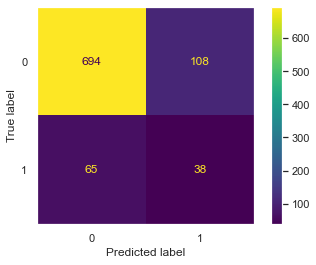

In [53]:
xtrees_model = ensemble.ExtraTreesClassifier(random_state=79)

xtrees_model.fit(x_train, y_train)

y_predict = xtrees_model.predict(x_test)

print(classification_report(y_test, y_predict, digits=2))

plot_confusion_matrix(xtrees_model, x_test, y_test) 
plt.grid(None)
plt.show()  

Our Objective is to identify factors that result in deposit = yes(1). 

As with most imbalanced data, this model is really good at predicting 0's but not 1'. 
Precision of 26%, recall of 37% and F1 of 31% doesn't seem great.

Our confusion matrix plot confirms this scoring.

### Feature Importance

In [54]:
feat_importances = pd.DataFrame(xtrees_model.feature_importances_, index=x.columns).sort_values(by=0,ascending=False)
print(round(feat_importances.head(5),3))

                       0
dayofmonth         0.081
bank_balance       0.077
age                0.076
campaign_contacts  0.066
house_loan_yes     0.059


Our Extra Trees model assigns an equal value of importance to several different features. Other models weight some features much more heavily in terms of importance, so this is interesting to note.

Additionally, we'll see in the other model scores that all models performed roughly the same in evaluation metrics.

### ROC AUC Score

In [55]:
# skilled model
yhat = xtrees_model.predict_proba(x_test)
pos_probs = yhat[:, 1]
roc_auc = roc_auc_score(y_test, pos_probs)

print('Dummy AUC-ROC: %.3f' % dummy_roc_auc)
print('ExtraTreesClassifier AUC-ROC: %.3f' % roc_auc)

Dummy AUC-ROC: 0.508
ExtraTreesClassifier AUC-ROC: 0.692


AUC-ROC scores better than baseline by 18%

<a id='gradboost'></a>

## GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       802
           1       0.33      0.41      0.36       103

    accuracy                           0.84       905
   macro avg       0.62      0.65      0.64       905
weighted avg       0.85      0.84      0.85       905



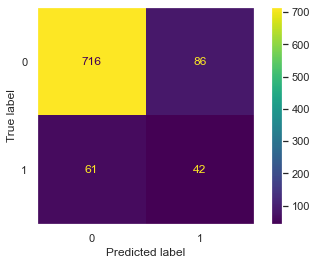

In [56]:
gradboost_model = ensemble.GradientBoostingClassifier(random_state=79)

gradboost_model.fit(x_train, y_train)

y_predict = gradboost_model.predict(x_test)

print(classification_report(y_test, y_predict, digits=2))

plot_confusion_matrix(gradboost_model, x_test, y_test)  
plt.grid(None)
plt.show()

Again we see our trend with the dataset imbalance. 
Our precision increases a little bit, to 33%, while our recall increases to 41%. F1 increases to 36%.

This Model Appears to meet our objectives with best over-all metrics.

### Feature Importance

In [57]:
feat_importances = pd.DataFrame(gradboost_model.feature_importances_, index=x.columns).sort_values(by=0,ascending=False)
print(round(feat_importances.head(5),3))

                            0
house_loan_yes          0.161
marital_status_married  0.110
bank_balance            0.103
campaign_contacts       0.096
p_outcome_success       0.081


The GradBoost Model weights having a house loan, being married, bank balance, and campaign contacts as good indicators of an association with our target deposit=yes.

### AUC-ROC Score

In [58]:
# skilled model
yhat = gradboost_model.predict_proba(x_test)
pos_probs = yhat[:, 1]
roc_auc = roc_auc_score(y_test, pos_probs)

print('Dummy AUC-ROC: %.3f' % dummy_roc_auc)
print('GradBoost AUC-ROC: %.3f' % roc_auc)

Dummy AUC-ROC: 0.508
GradBoost AUC-ROC: 0.747


AUC-ROC scores better than baseline by 21%

<a id='forest'></a>

## RandomForestClassifier

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       802
           1       0.31      0.36      0.33       103

    accuracy                           0.84       905
   macro avg       0.61      0.63      0.62       905
weighted avg       0.85      0.84      0.84       905



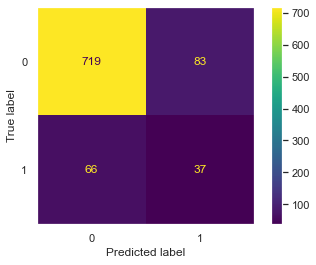

In [59]:
randforest_model = ensemble.RandomForestClassifier(random_state=79)
randforest_model.fit(x_train, y_train)

y_predict = randforest_model.predict(x_test)

print(classification_report(y_test, y_predict, digits=2))
plot_confusion_matrix(randforest_model, x_test, y_test)  
plt.grid(None)
plt.show()

Data imbalanced trend continues.
Our precision decreases with recall. F1 also suffers in this model, compared to GradientBoostingClassifier.

### Feature Importance

In [60]:
feat_importances = pd.DataFrame(randforest_model.feature_importances_, index=x.columns).sort_values(by=0,ascending=False)
print(round(feat_importances.head(5),3))

                       0
bank_balance       0.128
dayofmonth         0.100
age                0.097
campaign_contacts  0.080
house_loan_yes     0.062


I actually managed to identify a few of these in plotting, although the association was difficult to be sure of since it's impractical to plot every combination of features before modeling. 

### ROC AUC Score

In [61]:
# skilled model
yhat = randforest_model.predict_proba(x_test)
pos_probs = yhat[:, 1]
roc_auc = roc_auc_score(y_test, pos_probs)

print('Dummy AUC-ROC: %.3f' % dummy_roc_auc)
print('Random Forest AUC-ROC: %.3f' % roc_auc)

Dummy AUC-ROC: 0.508
Random Forest AUC-ROC: 0.742


Model outputs AUCROC increase of almost 25%, a good increase. 

### HyperParameter Tuning Test

In [62]:
# RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800, 1300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 3, 5, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8,10],
    'max_features' : ['auto','log2'],
    'bootstrap': [True, False],
    'oob_score': [True, False]
            }

In [63]:
# Don't Rerun
'''
rf = ensemble.RandomForestClassifier(random_state=79)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)
grid_search.fit(x_train, y_train)
grid_search.best_params_
'''

'\nrf = ensemble.RandomForestClassifier(random_state=79)\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)\ngrid_search.fit(x_train, y_train)\ngrid_search.best_params_\n'

In [64]:
# GridSearch Output
{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'oob_score': True}

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'oob_score': True}

In [65]:
## HyperParameters proof of concept
model_param = ensemble.RandomForestClassifier(random_state=79, bootstrap=True, max_depth=40, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=300, oob_score=True)
model_param.fit(x_train, y_train)

# make predictions w/ new hyperparameters
y_predict = model_param.predict(x_test)

print(classification_report(y_test, y_predict, digits=2))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       802
           1       0.32      0.34      0.33       103

    accuracy                           0.84       905
   macro avg       0.62      0.62      0.62       905
weighted avg       0.85      0.84      0.84       905



There is a slight improvement in relevent metrics here, but at a computation cost of about 1.5hours, the resource vs reward is pretty low. 

#### Model Re-check with fewer features

In [66]:
df3 = df[['bank_balance','dayofmonth','age','campaign_contacts','house_loan','deposit']]

#Dummy Encode
df3 = pd.get_dummies(df3, drop_first=True)

x3 = df3.drop(columns=['deposit_yes'])
y3 = df3.deposit_yes

trans = StandardScaler()
x3 = trans.fit_transform(x3)

x_train, x_test, y_train, y_test = train_test_split(x3, y, test_size=0.2, random_state=79, shuffle=True)

#Random Undersample
undersample = RandomUnderSampler(sampling_strategy=0.35, random_state=79)
x_train, y_train = undersample.fit_resample(x_train, y_train.ravel())

# Standard SMOTE, Random Oversample
sm = SMOTE(random_state=79)
x_train, y_train = sm.fit_resample(x_train, y_train.ravel())

### 3rd Model with hyperparameter adjustment
model_param = ensemble.RandomForestClassifier(random_state=79, bootstrap=True, max_depth=40, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=300, oob_score=True)
model_param.fit(x_train, y_train)

# make predictions w/ new hyperparameters
y_predict = model_param.predict(x_test)

print(classification_report(y_test, y_predict, digits=2))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       802
           1       0.19      0.35      0.25       103

    accuracy                           0.76       905
   macro avg       0.55      0.58      0.55       905
weighted avg       0.83      0.76      0.79       905



Model performance actually goes down. In this case it looks like the more features the model can get, the better.

<a id='fin'></a>

In [ ]:
trees =  data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAIBAQIBAQICAgICAgICAwUDAwMDAwYEBAMFBwYHBwcGBwcICQsJCAgKCAcHCg0KCgsMDAwMBwkODw0MDgsMDAz/2wBDAQICAgMDAwYDAwYMCAcIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCAHNAYIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKK+Xf+CnHh+w8VD4IWGqeBdR+Jenz/ABCPn+GLJ7RZNXUaDrB8thdz29u8fG545pQjorKQ+7Yx2t5FRV1J9lJ/cm/0PqKivij4S/8ABP2TxFpXwv0rx78PNFm8D6TqfirVJPCGoSW1/p/hq1vrhZdO06WAM0EwiT/lnGJIIZEGwkRxyHlP2w/+CcNx4m+L2g2mneFfiHrPwy0TwnZ6D4Ys/BTeFJrzwZPBPcGWSN/EStLas0ctt5dxp0yTL9kUMB5UDA+2od7fLS7v00em7Tez2ErWk+1/n71tOuq17+R+gVcvYfE77f8AGLUvB/8Awj3ieH+ztKt9V/tuWw26PdedLLH9miuN3zXCeVuePaNqyRnJ3cfO2o/s+3Fh+2fqfiDxr8F5vjFZXl5o8ng7xZK+jX7+A4YIIo5VdL+4hmt3W6SS7MlikrSecM/PGq1L8OfAes+BP+ClPi/xXpPwH17w/wCGvF+iW+j6j4otH8PQQanfQ3VzM2oXCR3/ANrkR45IkV2hM2RhkUDNEdZwT2fNfytFtX9XZdr7OSuxS0pyl1XL+LV/uV/+A7H1ZXL/AAo+J3/C1dD1C9/4R7xP4b/s/VbzSvs+u2H2Oe5+zTNF9piXc263l274pP40ZWwM4r5X/Y8/Z21n4M/Ff4hSL8FLi18H67pN9cX9/wCJtL8MDxb4lvZbjzBZ/bNOvHjvbV0ab/kIrFKrMheeYO3lcp8N/wBnrx5H+yT4x8AWPwN17wRosXjyTxPF4Wk1DQbWx8TaDLqn2ibRIRZX0sUTPbAo0U3lW77vLaTy3dhNNttX0vG/o+dKz9FeXdpbbXc1ZO3SVvVcrd16uy1sr9d7ffdFfC/hz9guXx7eeHrS8+ENn4L+FU3xKTxC3w/ubqxNvo9gnh6+s5XmtbSaSzWO4vnjZrW3klR1lLSLmSZV+g/2DPg3qnwA/Z5HhTU9LTRU03xFr76ZYRyxyRWmmy6veS2McYjZlSMWrw7Ixjy1wm1du0acul35fkv1f4a2egpaWtrf8NZ//Iq/+JbrV+y0UUVIBRRXx18PP+CcFv4Q/Y/1R/DnhvR/A/x+1Xwhq2ijxPDP5WoCe7DbVnvICzSIpWHyyxkEAjTy1GwLUTm4pu19G/8AgfP+rlwipSUW7XaPsWivz2+EP7B/ifwX+zR8UNO8HeEviZ4M1/xHb6Ss+geILjwhoum63Fb3XnXkFr/wjSJEk1zb+davc3KJIyyQgsFQ7Ot+OH7OX/CbfsoWfhXwJ+zEvw/8PXnjCK68ReFYNB8EPqU1sts3+n2VvPPc6O0xmFvEWuW8wRJLtUHy2rSa5XZa7fi0vuV+l3o7pLUiHvK703/BX/F6L+kfSv7Sf7RsP7M/hjTdbv8Awr4o8Q6Rd6jbadeXWjmx26QbieK3ilnW4uYXaMySoP3KyuOSVxzR8W/2jYfg58T/AAP4dv8Awr4ovbPx3qQ0i112zNidPsbto5ZUhnV7lLnLJC5DRwSKOAWBNfJ1j8Cvi18M/wDgmJoXwwHwz8WeKvFA8TS3KWlhqugIuj6db+Ivt1skjNc2lsqmzVFjjtYwiEBPLhUAD1j9rXxB8QfHF/8ABrUNB+CPxF1j/hH/ABJbeKtWt4dT8OxS6bGlteQNaP5uqIj3AaZG/dM8W3P73IxSfu1Iq91zxT/wu1/kld37/cG8J91GdvVXt97tp1WvmfUFFRWNw13ZRSvBLbPIiu0MpUvESMlWKkrkdDgkccE0l/YQarYzWt1DFc21zG0U0MqB0lRhhlZTwQQSCD1zRK60W4KzPLdH/a40vWfiT4y0keHfENr4Y8ASzW2veNry40218P6fPDbRXUsTGS7F18kcybpPs/lKQ2X+Umup+Cfx28MftD+DZNe8J3t1faZDfXGmytc6dc6fLFcQSGOWNobiOOQFWBGSuD1BI5rxD9jr9i3w1+yJrXxe8UaN8IPCujazfeI7+fw+PD2l6Zaahf6Qba0aOzgkDRrFG88L7YpZI0DgM20HdUv7Fvh7x7P4F+JegeIvBfj74R3fiDxNrOvaZrM93oF5LHHfXcksXkrDc3sYniUgsJ4TFkjHmDNENeVP/n2pPp775W49tnLTdctm3uyWzf8A08cf+3VzK/fdR12fNdJbL6Zor5s/ax/Znv8Axn+yovg/XLj4pfGqb+2YL5zFaeFGvrkRsXRLm2vIrPS57VWAzG8ZckqwO5Q6eba7+zx408QfCL4K/wDCa/Avwt4t8K+F4tWg8QfCzw5baVZafFJK6/2Zdrp93dnTmMESSB4DeSrFJds0TzeWGpdH5NL5Wvf79Nmr21Su0dUu6f3rp89z7cor4V/aN/ZK1Px9rt60fwC/4SfTNY8EWGj+ALVrzR7NPg5fxrMr/L9pAs9rSWr/AGnSvtEv+h7VBEUO/wBP8K/sEeH/AB58ePF/in4neD9I8TalHLoM3h/XbsrLdW09nZweZcWjhvNtJDcxAs6eW8gRAxZVUCv87fLXVfcuy1VmxPp6f5fnd+ejuk9D6bor4S/Z8/Yc8ReD/wBuu88a+LdH+Jk2vJ4m1fVI/F2m/wDCIpoepWNwbg2trc3ARPEMkKQSxRfZZWkhSW3i2kxRRlfu2ktacZ9Wr27DlpUlBbLr3CiivD/+Cgnwej+On7P/APYMvhfxf4wibVLW6bS/D8ehzvOYmLr9og1qRLGe23Abo3y2drIAyh1mcmldLqvz1+7cqKT38/yPcKK+MfD/AMPviz8OvDvwi8Qw/BnRZNT0Twr4l8MXXhbwhLpuhWWiG+u7CWxlaGW7eGCHy7L9+ltPdNG8h8sXCjNeAah+yTrGtWunfDbWPgvceOviJpPwB8JeH7O7bUtMFh4D1bzNYgF9JLNdK6vFKu5LiyinnRYpNmN+H0a3trZ29fj2vptGL1aXvpNq2rhG9Pnbtor+V5Rj/wC3N93bRan6m0V+dGr/ALN2ofFX9qj4m2mnfDi+13x3pPj/AMLyw/FK4urCK28LxWmkaFPd+VvuftyTTRRyqyW9uUn8+JJZdikx918If2TPFWg/tC+H9Rvfhh9g8b6L4x1LWdf+Lb6jYE+KtImN15NiGjmbUJf3c1pF9luIEtofsmUc+VDvFG7j2lbXyai762095+bS91S2WbbUea2tk7edm7addLer1tpf7cJ2jNYXwx+JmifGTwDpfijw3e/2joWtQC5srnyZIfOjJIB2SKrjoeGANfP37Kf/AATh+HXg34Q6RP4v+GHhU+OL3SbrS/EVxdWsN5Nq0FxKHe2vHBZbuECOHZHKXSMRoEChQBH/AMEwf2a7P9lv4aTeFn+Cll8OvEGkQJY6l4ns7TRo4PGnlyzCOdJLOd7p1CkOBdxRMvm4AJ3Yim3L4tNL/Pqvy899NCpaK67/ANf1+J9R0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVLVfDWna9eadcX1hZXlxpFwbuwlngWR7KYxvEZYiQSj+XLKm5cHbI4zhiDdooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqlD4a0628RXOrx2FlHq15bxWlxerAouJ4YmkeKJ5MbmRGmlKqThTK5AG45u0UB5FLS/DWnaHf6jdWVhZWl1rE63V/NBAscl7MsSQiSVgAXcRRRoGbJ2xovRQKu0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRWZ4z/tH/AIQ/Vv7H2f2v9jm+w7/u+fsPl59t2K/Nf/gliFv/ANpfwBf+Gm8MaXqbeD723+I+iaSsdxrMd2gtf9L8UXSksdXmv/tBigm/eQxi7+Zy0uwp+/Nw7K/4S29OXXtdO1r2J+7BT7u34pavpe+nezW9r/p3RRRQAUUUUAFFFZnjP+0f+EP1b+x9n9r/AGOb7Dv+75+w+Xn23YrOrU5IOdr2VyoR5pKN7X7mnRX5if8ABLELf/tL+AL/AMNN4Y0vU28H3tv8R9E0lY7jWY7tBa/6X4oulJY6vNf/AGgxQTfvIYxd/M5aXZ9RftPfFLwb+1b+xh4j1nw34z8Fp4U0TxBHbazceK7mbSPD+pjTtSRL3S72eRBstp2ie3eTy5Y2En3JkYq2tVezsr37vpbm5XLu0tHtfW1ubQim+dtWa6Wejvy35bdJbre2l78up9M0V+ZM0fgux/4JwftA3Xjz/hXPgv4Yapqd/J8OtJ0zW2tfCV1KdCjxFpvmLbR30El6LqaICARTTo1xHFkI9fef7KXxN8N/Fv8AZ48I6v4V8QaJ4m0r+zLe2+26TfRXtv5scSpJH5kbMu5WBVhnIIINEVfm/uqD/wDA03b1jaz9UEnbkf8ANz/+Stfnf5Wa6HodFFFIYUUUUAFFfOX/AAVRvr7Tf2Q7yeLTZdY0KLXNIbxPYrdC1ju9GF9D9sjnlb5Y7Ux5FwzfILfzywKhhXk3/BPD4n+Hv2cvgp8b/Gep+JvBqfBjw9qiatZ3/g/TSnhTTcWMLahFpEcAfzbSKXCF4gfNuRcttV2dFUZJxnKWij/9rq+y97fumnbS7kmnCKV3L/g6eum29mmr62+5qK+GP+CqPiPwb4v8U/CUeI7/AOF2neHtQ0rWdUtNU+KNrDdeDpH8q0MMLW1wqqdRkD5gk8xHhjW7PlzhmhbmPG37PPwv/aK/ZY+AXgW6+EmjP8Q/iZ4XsNHhv/Fmi2eqeJPCugWkEb31xJdyQrIrxxP5ULqse24vIGEacqHFSd1azUlH7+Za9rOLv2V29LXV46O+jTd/S23fR6W3ei1P0OoqvpOl2+haVbWVpEsFrZxLBDGvSNFAVVH0AFWKbtfTYSvbXcKKKKQwoor4U/4Kvvpkvxx+H1n4+T4d2/w4v9B1WGDVfiD5MvhfQ9WMtoftMtvMyx3V+LQXAtIcqzFrghlUSGolKzS73/BN/jay82r2LjG9327avdLbra935JvXY+66K+bv2Qfjnb/B39lH4BaD8Tdc1e38Y+O7SHRdGTWLWd9T1SZbeSaJbnCExz/ZYg0jS7MOCCQxAPy7+1Ne+EtT/wCChut3Go2fg+88V6V448J2+naLeCBviFqUQFlIbvQLho/OttLjJJnhQSLN5Wot51oS+/bl/fqiusuW/ndLbv7y06Xu9LtZRlek6j/l5vz69tHr1tbc/TOivzr+Fng2fQ/+Cg3hnT/C03wj8S+LdL8ba1eeOPFvhfVXvvFVxo88GoSJY68ghxZxQyvYwRQy3M3mNaQmKOEQlU/RSojrTjUXX+vu6dNU9Cpe7UdPt/m1r56Xtro1qFFFFABRRRQAUUV+XPge90PU/wBvH+09As/Bl58SJPH3iiCLTbYW/wDwsLRitpfxQ3usXIjE0uiOceTbOqCJJtPxcXChYVzlU5W1a+jem+ltLed/l10uy+X3ObzS121Ter+X9Oyf6jUV+Un7BGs+H9K+I+ha9JqXhbwrp1r8PNVX4u2WlXOzWbAxxW5mv/FF/CwlTV5Lz7S0UbkTQRrdbXZmk2fRf/BKDxV8JfiH4r+I/iv4Qah8PdB8K+KE06Sw8C+Gb+wMulwwrMn9qXtlasRZ3V4XAMbDeI7WDzSsu+KLo9n7zineyvptu19ztddd1Zcrtlz+7zWa1tro9k9u6vr02s3zRv8AaFFFFZlBRRRQAUUUUAFFFFABRRRQAUUUUAFFIRkenvXz1+xrY6p4X+PPx28PX/irxZ4rg0bXNLNvPr2pNdyI02k200xjTCxQK8rs/lQRxxKWO1FHFJPW3l/l/X9aHQ+hqKKKYBRRRQAUUVmeM9SvNG8H6teadbfbNQtbOaa1t/8AnvKqEon4sAPxrOrUVOnKpLZK/wBxUIOclBdTTor88f8Agnh8WPHeufHD4R6nJqviu+8P/FXwTe6tq6eI/EV5qN3rd1ClnLJq8FjLI0Gk2aXNy1tFDbrGJFmy8aiOGvsb4pfErwL4y+AvijV7j4g22leD9L8+DWtf0TXEgOni2k23UP2qIloJAUeJzGyzRknY0cgVl2qxdPR7q9+2js9e1+vTZpSulFJqo/dvZ2tprqr7d/L7tNT0iivgjUL34qeD/gd4a0DR5vGq6L8V/iVPZ+HrPxL4nvLHX7Hw82mz3EVrdarOZ760a4uLZ33/ALy9gguFiRUnULF9NfsReNbfxl8BooorK/0+48O6tqWgX0N14pu/FGLq0vJYZjHqV0TcXUZdSVeUK4GEKIUKAUb37q2nVaRbv6OSi99b+TY3a3Z316PWSVvXlbXlZq+tvXaKKKkYUUUUAFFeA/8ABSj4k6p8MP2Z1udOuPEVlb6r4j0XRtUutA3DVILG71CCCdbZlIaOaVX8lJFZWjaYOrIVDDif2CPijrnw70740WHxH1i30Xwx8PtYgnhk1nxVPrX/AAikE2nwXU1jd6teSM87wiRJZHkkKxm5MaMYo4zSg1JSk9FG/wCHK38rSWu26dny8xLRxit3/wAH8bxem+zV9bfWlFeI/ts/DLWPjR8FopvCHnXmowB7i2uLb4lax4LghheFj9p+0aYr/aSpEZWKYCI5J3p38F+L+nWP7QH7LHwc1DS/F3xcX4pfGLQ9L0fQL638Y614cePdbCe71e407T71bMPb25nuG+V0dxFFvdWTLSk+ZW1Tiv8AwK9vxVney630dh2XK76NN+lrfo799NtVf7ooqvpOnjSdKtrUS3E4toliEs8hklk2gDc7HlmOMknqasU3ZPQSu1dhRRRSGFFFfH3/AAUD8TeJ/En7SPgX4e6Wvi1rLWfDOratZQaP4nvfC9rPfwT2UX2m/wBRs5I547S0gnkkaJGbzWlQeW7Ku2JTs1Hvf8IuT8tk97K+7S1VJXTb6W/Fpfm+nQ+waK8K/Yl/aBfxR+yD8H9W8f8AijRz4p8a6bBbWl1czRWb+J7gRuyywREje80MZuNkecKzEDAriP219B8QfDn46eA/iBp1z4h0vQB4j0PTtUvbDx5qskk5ub1bP7Gvhx8aZNFJ50YkuPME8YaSRIneJd2zj+9VJdZKN/V26+q037Juyealek6nVR5rfp/X5Xa+rKK+ePhrYap4T/4KN+NtMm8V+LNc07U/BNlrX2PUtSaSzspn1K9jAt7ZQsEIWJI48pGHcRhpHkcs7fQ9ZwfNTjU73/CUo/nEqXu1JU+1vxipfqFFFFMAooooAKKK+ZtIfxD8Ov26viXBaeIfFnigXHw8t/EFrpepak0tnDdm/v1jit7ZAsEIEccUWUQO4QNI8jlnbKpVUH73aT/8BjKf5RZcYOUW13iv/ApKP4Nn0zRX50/sD/Ebxv41+LXwtnutX8ZXfhr4weBNQ1DWhrnim/udQ1q5jitJJdYtrUymPRrVLi5a3hjtREXEwZkTy4a9y/YTs/Enw4+PXxQ8DeJZ9agms7DR9bs9Jl8a6j41sdOhuDeQl49U1IJeebK1qS9s8SxxhEaNpDLJt6ZU3GThLdX+9Np/lfv0aTTSxU0488dtPxSt+Lt27N3R9SUUUVmWFFFFABRRRQAUUUUAFFFFABRRRQAhG4YNeb/C79jb4QfA/wAXNr/gr4VfDfwhrzRPA2paJ4ZstPuzG5BdDLFGr7WIGRnBwM16TRQtHdbhurBRRRQAUUUUAFFFFAHI/D/4A+BPhP4n13W/C3grwl4a1nxRN9o1m/0rR7ezutXk3M++4kjRWmbc7tlyTl2Pc1BqP7Nnw61f4b33g278A+Crrwhqd097eaHNods+m3c7y+c80luU8t5Gl/eFipJf5s55rtaKVla3y+X9Id3e/Xf5nmekfsXfB3w98N9U8G2Hwn+Glj4Q1ydLnUtDt/C9lHpuoSoVKSTW6xCORlKJhmUkbRjoK7nwb4L0f4deFbDQvD+k6boWiaVCtvZafp1qlra2cS/dSOJAERR2CgAVp0U7sQUUUUAFFFFAFDxT4W0zxx4bv9G1rTrDWNI1SB7W9sb63S4tryFwVeOSNwVdGBIKsCCDzXOaP+zr8PvD3wlm8A2HgXwbY+BbmOSKbw5b6LbRaTKkjFpFa1VBEQzElgV5JJNdlRRZaruF3p5HDfE/9mL4a/G620eHxn8PfA/i6Hw6CNJj1rQbW/XTAQgPkCVGEWRGmdmPuL6CunufBukXniiy1ubStNl1rTbeW0s9Qe1Rrq1hlKGWKOQjciOYoyyggMY0yDtFaVFO7/rz3+8PIKKKKQBRRRQAVynxc+BXgj4/6BBpPjzwb4V8baXa3Au4LPX9Jt9St4ZgrKJFjmRlDhWYbgM4YjvXV0UBdrYxNc+GnhzxPqGh3epeH9E1C68MT/adGmubGKWTSZdhj8y3ZlJhfYzLuTB2kjoaxR+zd8Ox8YT8Q/8AhAvBf/Cfldh8Tf2Hbf2wV8rycfa9nnY8r5Pvfd+XpxXa0Udb9f8APcOljzbTP2NPhBovxTPjmz+FPw2tPGzXcl+fEEPhmyj1U3Mm7zJvtIj83zG3Nufdk7jk816TRRQtFyrYHq+Z7hRRRQAUUUUAFebaZ+xp8INF+KZ8c2fwp+G1p42a7kvz4gh8M2Ueqm5k3eZN9pEfm+Y25tz7snccnmvSaKNnzLcN1yvY4XQv2Xvhn4Xn8Vyab8O/AunSePFkTxM9roNrE3iJZN/mC8Kxj7QG8yTPm7s+Y2fvGtL4TfBHwX8A/DUmi+BfCHhjwXo8s7XT2Gg6VBp1s8zBVaQxwqqlyFUFsZIUeldRRQtNvT5dgeur9fmFFFFABRRRQAUUUUAFFV9V1KPRtLubyZbh4rWJpnWCB55WVQSQkaBndsDhVBYngAk4rzDwz+238N/EvhfxRq76vqugW3gy3ivNZh8S+HtS8PXllBLvEMv2a+ghneORo5ERkRg7oyKSylaV1r5av0CzPV6K8uH7Y3gaH4XT+L71/F2jaTDqCaVHDrHg3WdM1O+un2+XDa2Fxapd3TvuAUQQvuIYDJRgNbwl+0h4U8ZTaJBBNrmn3niLTr/VbGy1jw/qGkXj21lLDDcyPBdQRyxbXuIcCRVLiQMgZcmm9L36f5X/AC19NQWtkup3dFeI+J/+Cifwk8J+HdC1SbXdbvrXxJ4ei8WWC6T4V1bVJ30mQEi+eG2tpJIoRxvaRVEZZA+0suei8Uftd+B/BnjzSvD+p3HiO1m1uS1hstTPhbVG0KaS6Krbp/agtzYq8jMiKrTgl3RMbmALs78vW9vndq3rdNW3un2B6b9r/LR39LNfeu56ZRXm0X7Wngq9+KF94QsZfEuratpcksF7PpfhXVb/AEuymiiM0lvLqENs9nHOqYzC0wk3Mi7dzqpu+Dv2mvBHxAuPBMWja2NRk+Imjy6/oAitJz9tsIlhaSdvk/cqPtEI/e7DukC43cUo+8rx/rf/ACf3PsD0dmd5RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeFftcftjXX7O2uWOj6No3hvVdTbR7zxJqVz4j8RtoGk6Rpts8MLSSXKWt05lkmuIo4olhw5EmXXaoaXJLfz/BNv7km35Iai3t/V3Zfe2ku7aR7rRXGfs7/G/TP2kvgd4X8d6Pb31np/inT4r+O1vY/LubMsPnhlX+GSNwyMOzKa8f8Aix+3frnw9/ahh+Htj4I0fUlbUNNslhufEU1n4h1eG5aLzr/TNOFlJHeWdqspM8xuovLNvcbwgVDJo4tVFS+03b5/kSpJw9otrX+R9J0V5L8Pv2jda8V/tTeKfh1qvgw+H7XRtGh1rTtRl1aO4uNThe7uLXc9vGhSFWa3Lp++dzG6b0ifdGvrVStYqa2d/wAG0/xTQ3pJwe6t+KTX4NMKKKKACiiigAoor5l8O/8ABRL7T460STWvDuh6R8PfF2vax4Z0DWY/En2nVpr3Sxdm4a508WypBAfsF1h47mZx+43xxmRhGnJLV/1/X49B2bV1/W7/ACT9D6aor438Mf8ABWf7VJqKa34M0rTLm68B3vxC8O2Fp4la+vpbKCAXMVvqifZETTrqe3ZZY40kuQVSc7v3a7/Xv2JP2q7n9rj4fXfiJn+FMtpE8UcR8EePD4rSF2jEjw3T/YrUQTIGT92N5+bJI4zXK7yj1jq/K7cfzi1bdWJbSSfR6Lz0T/KSd9nfQ9qooopDCiiigAooqG/v4NKsZrq6mitra2jaWaaVwiRIoyzMx4AABJJ6YobSV2CTbsjn/jR8Pp/i18H/ABT4Wtta1Dw5ceI9JutMi1WxOLnTWmiaMTxnI+dC24cg5HUda+VPhf8A8EgrTwD4V+IVoviHwZ4fvfG9joEdv/whHgODw5p2lXujXk15a3n2X7RP57PK8RlEkmXETAOqsoj+j/Df7XHwp8Y6tcWGkfE74e6rfWkNzcT21n4js55YYrbabiRkWQlVi3LvJGE3DdjNXPhr+0v8OPjP4T1PXvB/j/wT4r0PRCw1HUdG1y1vrSwKp5jedLE7JHhPmO4jA56Ul7rlJaaK/om7Pys769/Qd3JKHnp66P8ARaf5nAePP2bfiL8WfAvh9/EPxB8Ip4+8FeJo/Enh7WNI8HT2ulwslvJbGC6sZtRnknR4ri5VjHdQt+8QqVKZav8AEn9mP4mfEO68IeIE+JnhTR/Heg6Xq2hahqVp4KlfT7yy1CS2dzb2kuoO0FzH9jt9kkk88e4OWhYMFXt9D/bC+Enif4eXPi7Tfil8OdQ8J2Vy1lca1beJbKXToJ1i85onuFkMauIvnKlshfmxjmk1X9sX4R6F8LdN8cX3xT+HFn4K1m4a00/xBP4lso9LvplLhoorkyCJ3BjkBVWJHlt/dNE4pxalt1+cbfjH7/McZNNSW/T0u3+Db9Dnf2Y/2QP+GcU8HqPER1keE/h/pvgXLWP2c3f2Nmb7Uf3jbd+7/V84x9415d8dP+CWn/C8P2o3+It34m8JsB4k0LxHaSah4Jjv/EOk/wBmSWr/AGCz1RrkG3sZjbuzRJAGElxK29gzI31rY30Op2UVzbSxXFvcIssUsTh0kRhkMpHBBBBBFcdqv7S/w40L4t2vgC+8f+CbPx3ehTbeG59ctY9XuAyl12WpcStlQWGF5AJrRykqsZP4lJtf4nJzen+Jt2+WxGjjJ9Glf0SUV+CSOG+GPwG8Xfs5eNfEV3pfjTRrz4Y6lrOp+KLrQbjwjcXmuwz3jSXNxHbXsF2qtH9pd5EjNlLJtYxhmO1l5T/gn58GbnQtd8c+N59O1fRtB1rUJdP8EaRq+nyWF5pGiLczXTFreXElv593c3DrG6I4t4rNXRWj2r7zY/FrwrqejWGo23ibw/cafqt8dLsrqLUYXhvLsO8Zt43DbXlDxyKUUltyMMZBrnvBf7W/wp+JPxIufB3h34m/D3X/ABfZPNHcaHp3iOzutSgaElZg9ukhkUoQQwK/KRziop6PTWy5V5bX87pWV+kW77qzqe8nzdXd+b1t98rvzkk+h6FRRRQAUUUUAFFFR3V1HY2sk0zpFDCpeR3OFRQMkk9gBSclFc0tgSbdkSUV4b8Bf2+fC/x7+IWl+HYdC8VeGpvFOjS+I/CtxraWccfivTIpI0e8to4biWeJP30LBbuKCRllBCHbJs7z9on452P7N/wi1LxhqOl6xrVtp0ttAthpSwG8u5bi4it4kj8+WKLJklTl5FAGSTTleKvL+tbffdNNb30Bay5V/XX8ne521FePa9+1peeFPBei3eqfCv4j2XinxLqsmk6P4QMujS6vqLxwPcPKsseoNYxxLDFK5Mt0h/dlQCzIr9p8EfjLpfx6+Hlv4h0qG+s0ae4sbyxvkVLvS7y2meC5tZgjMnmRTRyRsUd0JXKO6lWLs/6/r/htnqK/9ff/AJP1tc62iiikMKKKKACiuP8Ajr8a9K/Z++G9z4k1aDUb6OOe3srSw06JZb3VLu4mSC2tYFZlUySzSIgLsqDdudkUMwyf2dv2mNI/aMtPEcVppuq+Htf8HaodG1/QtVktJL7R7ryo5lSRrSee3bdFLG4Mczgbip2uropH3r26f8D/ADV+113QPSzfX/g/5P7n2PRqK8/+N37Qtn8Gb7RtKg0HxD4x8V+JPObSfDuhLbfbr6OAIbibfczQW0UUQkTc800Yy6IpZ3RG5n47/tkxfs7+ErfXte+HnxEfRLbTY9W8RX9rDp7W/hG3Y4Zrt2u1EzR4kLpY/amVYyxGHiLi129P6/z2Q7P+vu/4ZbvoezUU2KVZ4ldTlXAYEdwadQJNNXQUUUUAFeE/tT/sbXPxy+Kvgzx/4b1zQNA8aeCobm1tJte0CTXdNeOZopFlNql1an7TBLCjwymQiMtJ8jFlZPdq8s/aE/aqsPgHrek6PD4Y8U+NvEOr2d3qiaVoJsY5rawtPL+0Xk0t7c21vHEjTQr80u9mkG1WCuViTimpPRrby0d3917vort6FRu7xWt/x/p2t52tqVPBP7NWufCDwF8K/Cvgvx1c6N4f8ByqNdju9JgvrnxfB5EitHJKSotnedxO0kS5LLtACk1578Tf+CeGo/EP41+IdaXxppFp4W8XeKNF8Xanav4aM3iCC70tbdbeOz1QXSrbwf6MvytayMonugrr52V98+D/AMWdB+PHws8PeM/C98upeHfFFhDqenXQUr50MqB1JU4KnB5BGQQQeRXL6p+0vC/xol8E+HvCPi3xjd6VPbweIdR0r7DFp/hdp0WSIXL3VzA0jGJxKY7VJ5FQqWRfMjD7NSjW1VpJ39Gmn6JJxWnwp+b1zjZ09NrW+Wvzvrvu/kcrof7OXxM0/wDbIvvibdfEDwLcaHf6amhNocXgm6iu10+K4nnhUXh1Rk+0Bp8NL9n2MF4iTOR7tXhPhz/goH4S8RfGPTPCx0bxPYaZ4i1u+8M6D4nu1s00jX9UshKbm1tlFybwlDb3C+bJbJCzQMFkbfHv92qIaUoqPw9Pn73rre+ve/UqetSTl8Ttf5e7+FrfK3QKKKKACiiigAr5yb/gnro/ir9pu7+Ifie3+HkoS7uLyzh8PeC00fUr+SW2mtA2rX5uJpL9o7eeVU2rAoZyxViECfRteJeGP26fD3iL4i2mkzeHfFukeHtY1O+0TRvFt/HZpout39kJzcW0QW4a7jZfst3h57eKJ/srlHbdHviSi3eXZ+lnv5f1oVeSjp/W/wCl7+W5wv7Mn/BOTUP2bNQ0lrfxjoeoWngbS7/T/B8S+GZIJY57tYo2v9XmN476ldiK3gi3x/ZFKeYAo3J5Xo37Pn7NWt/Dn4s+MviF4z8UaT4o8beNLSw0y4l0XQn0PTLezsvOMCLbvc3UjS77mctLJO2QUVVQLg8f4Z/4Ke+Cddsr66vPDvjTQbVvCd9458PyajFYq/i/RrMK0t1ZRR3Tyxgq8TKl4ls7CUEL8smz1T4BfGrU/jh4afVL74e+M/ANs8cM1mPEM+lSvqMUi7g8YsL26CgDGRKUb5hgHnG15NtvdLr5uS++6ku+jT0VlDUUuXo3020UX00trF9rtPdne0UUVAwooooAKw/iZ4an8Z/DfxBo9q0SXOq6bc2cLSkhFeSJkUsQCcZIzgH6VuVy9h8Tvt/xi1Lwf/wj3ieH+ztKt9V/tuWw26PdedLLH9miuN3zXCeVuePaNqyRnJ3cZ1acasXSltJNfg7/AIXLpzdOSqR+zZ/irfifHfwv/wCCZXxH+EdtcXPhzX/BXh7X4tJSz0zUbQSyGxni8IWejQybDAoZY7y3kkAPHlsDjcWjqHwl/wAEzviRf+GfiudZ1HQNO1DxvpHhmDT7S+8a6743ie40e/ubx4ru71JEmNrdGREZIlCossoEbEbpPs74yfFGw+CHwi8UeM9VhvLjS/CWk3Ws3kVoivcSQ28LSusYZlUuVQgAsBnGSOtXPF3jzS/AXgHU/E+sXBstF0awl1O9nMbSGC3ijMkj7UDM2FUnCgk44BrarWfNKvN20V325dn/AJ307oinStThQirrZLvbk0/CPnrpuzybxX8LvH37QGieCZPHHhzwD4fvvCfja01+Sy07xBc67az2tvFJsdZZrC1IuBNICqeXtHlhhJngUfjR+zz4q0D49aH8Rvhj4f8Ah7q9/b6Tqejaho3iC+m0a2c309vcSX0dxb2l0fPZ7ZVkVof3quCZFMeH910TWbbxHo1pqFnJ51nfQpcQSbSu+N1DKcEAjII4IzUmoXq6dYTXDhikEbSMF6kAZOKzmlS5nJWs5N/OKhL74x1+9WdrEX7SzWt0kvlJyj9zf9I4n9mD4Nyfs9fs9+EPBMt5bahL4a0yKxee2tvs0Dso58qLc3lxjoq7jtUAZOK+cf2mP2Ifiz8dv2lRrf8AbmlXHhGz8WeHNf0sz+Ntbsl0yy0+4s57ixOiQR/2fcyySQzyrdzu7gyImxQiPH9Q/A/4t6d8ffg14U8caPDe22k+MNJtdZs4rxFS4ihuIllRZFVmUOFYZAZhnOCetdTW0lKFdTlpKLv807/mvzWzaaj/AA3FbNW+X9f5rWzPnHQf2SdY8EftIan4lkudPuPh1o99qfjDQdItzNJexa5f26w3TNFhYyig3siESEs+qTDbH5as/wAs/wDBHj4m2+tfFD4f2LavpfjaRPAE1lpiaX4ytNWufh5ZB7OV7HULC30q1awaVxEgW7vb2ZZLUxq74mlP6aUVnR/dyT6JWX3SS18lK3+HTqOp78Wu7u/PVP8APX1dwooooAKKKKACqHinw9B4v8MajpN3v+y6pay2k2w4bZIhRsH1wTV+kJ2jJqKkIzg4T2a19CoScZKUd0fG/wCxX/wTw8U/An4q+FdY8V/8InN/wgOkXGlwa9Zanc6hrPjGV4obWC4u1ltoUsIYLWFkjsoXnjVrhyHBUtL7Vqfgvx58R/2d/EujfETwd8IfHWuX99crbeH5ri4j8O6hYC63WiXck9rcv5ohCNIRbunmr8oAwRo/Br9sX4efH/xTNo/hXWr29u1t5Ly1e50a+sbbV7aOQRSXNhcXEMcN9ArtGDNavLGPNiJbEiFuv+J3xN0X4O+CL3xF4hu5LPS7Hy1doraW6mleSRY4oooYleWaWSR0RIo1Z3d1VVLEA3VbmuafVb97vfturLololYmnFQlywVrNafLbv5976nyn4S/4J8634L+Amq6cngvwFJq194yk8T6H4X0Pxvq3hPR/h/G9sLZotL1Sxs/tcZcCR5BFb28cjXlwu0KT5nvP7G/7N0f7KfwIs/CQu4b66N/f6vezQI6Qm5vbuW6lWMOzv5aNMUUuzOQoLEsSas+C/2ufAHjr4deJ/FUGsXml6P4Ld49e/t7R73Q7rRykCXB8+2vYYZ4wYZI3UmPDK4K5zXT/CT4r6D8c/hpovi/wvevqPh7xDareWFy9tLbNNE3QmKVUkQ/7LqCO4qrtXXlH7rWj63SWru3bcTs7X7t/O7v9zk9For7HRUUUVIwooooA8i/bc/Z51T9pb4Fvomgas2ieI9L1Sw13SboXDWw+0WlwkwiaZUkaESKrx+csbtF5gkVHKBT57+zz+yr48/Zu+EHxM1Dwlo3wv8ADnxD8V+W2gaEl7e3vhvR/s1ssNutzd+TDdXTSSedcTTeSkjvOR8xUyv798VPipoHwU8A6h4n8T6gumaLpaq085ieZyzuscccccatJLK7siJHGrO7uqqrMwBpfBv45+G/j14eutS8N3V/Imn3bWN7a6jpd1pV/p84VX8q4tLuOK4gco8bgSRqWSRHGVZSVGPuzhHrq/J6K/rol5dN3dveM5LbRfi7fi3b7+h4t+2F+yJrPx88SeBPE8ng34X/ABJv/D+lXuk6r4X8YX1xaaDd/avsspuFK2t2JGimtF2RzW7AiTcHjdFJ4/xt+yv8c7bwJ8LfAFmnw78efDnwdodtH4hstW8WahoVx4n1GBl8qKZl0++ZtOj2KfJMgechVlZolkjm+jPjR+0h4V+AcmmRa++vz3usea1nYaH4d1HX7+aOLZ5sv2awgnmESGSINKUCK0salgXUHGg/bZ+F95q3gOxtvFUF5dfEuCC58Ppa2dzcfaYp45JIHlKRkWqyrDNsNwYw7QyquWjYCoPX3P5lou7crL1u211vtsJr3fe/lf3aXf4WfQ9PsXmksomuY4orgoplSKQyIj45CsVUsAc4JUZ9B0qWiik9WC2CiiigAr5m/bb/AGOtf+N3xW8KeM/Dun+GfFP9kaZdaNq3hXxJrVxpOka3DJNBcwPPLBa3TTJDPbgm1aMRzeYN7ARhX+ma4H43/tNeD/2eG0qLxLd6ub3XDN9g0/R9Cv8AXNQuUhUNNKtrYwzT+VGGTfLs2IZEDMC6gzKyak3Zrb5pp/g2u63VnqVG7Tja9+npr+auch8Ifgp4/wD2cvhL8I/BPha98Harpugy+T40vtUjuYJ7qBopXkk0+KMsqSNdupCysVWLcMlsGvJ/i9/wTz1zxd+03rfifS9D+HNxF4j8S6T4mh8Z6nfXX/CTeDmtVs0uLbTrdbdo9s6WSKZFurfIuHEscyxhX+tPCPi3TPHvhXTdc0W/tdV0fWLaO9sb21kEkN3BIodJEYcMrKQQR2Nee+OP20Ph58OfiZ/wieralrUepJe2mm3FzB4c1O60rT7q7Ma29vdajFbtZ20snnQYSaZGxPESMSIW0s41k0rSvt846L5paLW/rYzVnTsvht/nr26+h89/Cj/gmd4h8D/HzSLm/wD+EWvfC3hnxZdeJbDxFNqlzda/JaNLdXNto0Vm1skFlbx3F2ZJJY7mRrg2yF4wXHk/a9ea6T+1z4C1v40DwDBqmojxFLLcW9sZtEv4NO1Ce3GbiC2v3hFncTxAPvihmeRPKlDKDG+30qph7tNRjtv67K/q7K762u9bsqX8Rye+3pq3b5NvTpstEkiiiigAooooAK+RZ/8AgnCnjb9pGLXdQ0HRfCHg/QtX1LWLK30rxjqurNq9xe211bSSDT54orLSC32uaaUWglaeVlLONrGT66rzLwr+2F8PvGnxWk8G6frF9JrAuLmzhnl0W+g0u/ubbP2i2tdQkhWzup4tkm+GCZ5E8mbco8qTbEoRk7S7P7uvnoVzuMb7K6/X5aq/nvY+b/2Y/wDgmz4p+FPiDTLnxXpfw/8AEX/CHeG77RILybVbm9vPiDLLbx2kB1LzbJU0+0itYmjWzhF3Gn2qQgkqfO9P/Ye/ZF1L9njx5478Qz+Gfh78NNL8WR2EFr4I8CXEk+h2L2yyiS/Lta2im6n81UfZbIAltDlpDyvV+Ev2+fhT43s9dudP8R3ps/D+lXWuy3dzoWoWttqGn2pxcXlhLLAqahBH8uZLNpl/eRc/vE3dX8D/ANobw7+0No9xf+HLfxdFaW3lnzNc8JaroHnrIpZWhF/bQGZcD70e4DIyRkZ25pSk57u2r8m3q/V3S6K1opW0zcFFeztZX280lp8tG+uuraZ3FFFFQUFfGH7WPwA+M5+N/wARNf8AhjY3h0/VdHsdbijt9WgtU8R6pFBcabLpsqPKmF+xyLMHfbGJYoDuLJ8v2fRUVKcZrllt/X9eezurounUcJc0d/6/Pb8rOzX52aV/wTa1zwz+1Nod1rOi/ErVtM0Gfw8nhfxF4V/4REW/h2wsbOzgazmuNQQazbR+dbzvLHp8pjmiunwu+WZT694T8J6r8Lv+CiPjrxtp/wACdd8OeFfEvh6LTNU8VWr6BBb6jeW9zdTvqNwkN8byRHjeNQ7QNPkYMYAzX1rQRkVdVznaV9VzffKPK799PPzetjOEIxh7N7e6v/AWmrdFt28kraH49/sxfs+xeNvh/dPN8PoIPH/xY+DHiGz8B6zb+GdH0yTxk11bQyTXd7fpqtzd3V3J50G26urawGJ5vMRHlEa/WviD/gmfpGqXnx18LWHgLwtZ+CviB4D0m301LyCC5tLrxHF/awlv5o2Lu12vnWTvdyKZJCFbzHZDj6U+FP7Lnwz+BGu6hqngf4deBfBup6uuy+u9C0C106e9XduxK8Mas43c/MTzzXd0V4xqUvYrRWa87Xk9+rXNe9lrrZGkaklPnerve/n7nTp8CVrvRtX1Pz/+IH7GepeN/wBjfwf4Y8L/AAI1T4Xafo3iK1vPGfg7R7LwcLrxgi6fJA1xFFNJdaTdbbh4JNt+EZhbb12SRxEu1P8AYj1TSvAHwt0mf4Q+KPiv4G0fTNet/wDhC/G934a3+H9Vu7mF7O8nt7d10tbWCJbmKMWayvbRTgRQEllH39RTrP2rm5fad3/4Dy6fmuz1VrK0U1yRjGP2VZfff9bPutHe7v5Z+w78NtZ+Df7GXwp8JeIrJdO17wz4R0vS9RtFlSYW1xDaxxyIHQlGAZSMqSDjg18pftW/sifEv4q/t32njXSvAU0cuheLPDVzpHibS7fwvbQyaLBNaNqAuryeM64brBu08mCSO3eAKuWJdJf0Aoq51XPELEv4lLm8r3v/AF5CikqbpLZq3yPlHwl+zN4i8C/HeTTb3To7b4NeBtc1T4haJcfaYTHNf3kRK2ZhXdKq2txcancD5Ag82z2F2jYJ85f8Emfh7onh749fDjxZ4k8EwaT4j8aeBbyfwn4ig8KaVYyeKoXa0uLu/vryHU7u9vLpkeEi5uLSxJE0weNZJhEv6dkZFcJ8Kf2XPhn8CNd1DVPA/wAOvAvg3U9XXZfXehaBa6dPeru3YleGNWcbufmJ55rOh+7kn2Vl90o693ZpX3tHXmbuOr78Wu7TfyfNp297mlbZuWnKju6KKKACiiigArN8ZeH/APhLfCGq6UJ5LX+07Oa08+P70PmIU3D3Gc/hWlRUVacakHTls1b7yoTlCSnHdanwl+wt+xt8QvBnxu+HWteOfD+tadqPwv8AC9z4evdcvtUspNP1YeVb2ttaaNaW08rQaeqQSTu9ykFxJI8JdXIxD67+0Xp/xP8A2jf2M/FOnSfDkeH/ABLPraW40E6rp2pXWo6Tb6nGWntppR9liu57SNpIRKR5ErR5dWTePpCitKsnUfNPX9Xzc13+T6NN3TepFOKp/BotPkkrW72263VlZpaHxB8Pf2Mvix428JX8EF/ZfDrw3H45HijTvD/j/Sl8X6vqUcVrbrANVurLVYzctFeRNNE0t3cybIbRZHPlCMe2/wDBOL4S+PPgb+x74P8AC3xFm0ZvEOk2vk/Z9OsTbCxi/hhkb7TcLNIDuJkRlUhgAg2kn3KihOysuy/BJX9WkrsLfr+Lb+7VhRRRSGFFFFAHif7fvwg8WfGP4Axw+B5FHinw7r2l+I7GEpE5uzZXkU7RIJmSEylFYxCV1i81Y97Km5h5n+yp8HfG/wCzL8NvjJ430j4deI77xN4puotQ0bwjr/iiyfXNcntrNITPqF+ks1pHc3U/mMSkjxxxLCAF2+Un1xRSStGUY/a/BtRV18orTVabXsDs5RlJbfitdH/4E9d9XrbQ+U/26fhP40+LXiX4carF4H8Za/omnaVqi6pY+Ctd07S/EWm6jcRW6wFb66uLXNooFwJY4pwJnEHmRTRBkrnvH3hj4u+E/hX+zhoMvwl1nxrrfw6vNL1rxHd+EJ9B07SYWgsbq1ktbeG5vbQh1aWMhY4Ug2n5WXGwfZtFNWTvHT3oy+cW5L8X62SV7IPs2evuuPykrP8AD5at2IrG4a7sopXgltnkRXaGUqXiJGSrFSVyOhwSOOCaloooerBbBRRRQAV8pft4fAHxn4u+N/hPxh4f0fxb4s8Njw/qHhrxHoXhbUrHTdYu4pp7W5iVLm7ubZIbaRrdo7hopRPt8sIMM7L9W0VLjdqXVX/FOL+9NopOyaezt+DTW2ujSenY+f8A9m/wN45/ZN/Z7+Cnw+s/Bdn4k8oLp/ie7sdYhtbPwlCYpZjJCkih7mJJikCRxqrbCGO0LivH/jb+zf8AE/xL+2DrmuaX4P1a4lvfFfh/UtE1+LUNLTwnb6XaLbfal1WweZbm7vgUuvJnNtNJCfsfkT24WTH3BRV3/eqr1Tv+Kdu9tPVptN2djNRtT9n0tb89fX8NFZXPlnSJviP8V/24LXVfHXwf8Zad4P8AAmoXVv4Ivbe/0GbTUaS3aCXWbxhqP2zzHjeWGGCO2/dRzO0nmPIPs/1NRRSWkVHt17+v9eS0SSp6zc+/4en9eb1bbKKKKACiiigAr4luv2H/ABN44/aA0vTdPb4o+Fvhx4N8Rav4hgTxBqujT6Y9xe2uoQk6VHZmS+ZWnv5ZidRkXyVASJBvIj+2qKidNT0ltZr7/wBV0KjOUV7v9br8U7M/PP8AZq/YR8aDxB4df4l+CPEt9/wgngPUvCWr3EmtWAtvE8MlrDZwabocEF3/AKNZGKKWRpbo2s7yyQs+SD5PvX7CHwq8Z/Drxh41mu9J8feDfhvdQafb+HPC3jXxYPE2r2NzEkourlbgXl6IbaRWt0SAXTgG3d9kW/DfSVFbOo3Jze7389W7v735dd7sz5IqPJHRLby0Ssr6/ZXnbS/LoFFFFQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcH8UvinfeBtcgtraC1lSWASkyhiQdzDsR6V3leO/tD/8jdaf9eY/9Devxzx2z/Mcm4TqY7K6rpVVOC5lvZvXc9rIMPTr4xU6qurMP+Gh9X/59NO/75f/AOKo/wCGh9X/AOfTTv8Avl//AIquBor+Hf8AiM/G3/Qxqf8Akv8Akfe/2HgP+faO+/4aH1f/AJ9NO/75f/4qj/hofV/+fTTv++X/APiq4Gij/iM/G3/Qxqf+S/5B/YeA/wCfaO+/4aH1f/n007/vl/8A4qj/AIaH1f8A59NO/wC+X/8Aiq4Gij/iM/G3/Qxqf+S/5B/YeA/59o77/hofV/8An007/vl//iqP+Gh9X/59NO/75f8A+KrgaKP+Iz8bf9DGp/5L/kH9h4D/AJ9o77/hofV/+fTTv++X/wDiqP8AhofV/wDn007/AL5f/wCKrgaKP+Iz8bf9DGp/5L/kH9h4D/n2jvv+Gh9X/wCfTTv++X/+Ko/4aH1f/n007/vl/wD4quBoo/4jPxt/0Man/kv+Qf2HgP8An2i9+0N+2V4i+EXwB8ceK7DTtFuL7wx4fv8AVraK4jlMMstvbSSorhXB2koAcEHGeRX5Xf8AEU98cf8AoRfhT/4B6h/8l196ftt/8mY/F3/sStZ/9IZq/nWr+9fohZzjeKMnzDEcQVHXnTqxUXLonG7StbqeBnGW4alOKpwSP01/4invjj/0Ivwp/wDAPUP/AJLo/wCIp744/wDQi/Cn/wAA9Q/+S6/Mqiv69/1cy3/nyjx/qtL+U/TX/iKe+OP/AEIvwp/8A9Q/+S6P+Ip744/9CL8Kf/APUP8A5Lr8yqKP9XMt/wCfKD6rS/lP01/4invjj/0Ivwp/8A9Q/wDkuj/iKe+OP/Qi/Cn/AMA9Q/8AkuvzKoo/1cy3/nyg+q0v5T9Nf+Ip744/9CL8Kf8AwD1D/wCS6P8AiKe+OP8A0Ivwp/8AAPUP/kuvzKoo/wBXMt/58oPqtL+U/TX/AIinvjj/ANCL8Kf/AAD1D/5Lo/4invjj/wBCL8Kf/APUP/kuvzKoo/1cy3/nyg+q0v5T9Nf+Ip744/8AQi/Cn/wD1D/5Lo/4invjj/0Ivwp/8A9Q/wDkuvzKoo/1cy3/AJ8oPqtL+U/pq/4I7/t4+KP+CiH7LOp+OfF2laBpGp2XiO50dINIjmSAxR29tIGIlkkbdmZs/NjAHFfV1fnF/wAGvn/KO/X/APser7/0jsK/R2vybOqMKOOq06atFPRHi4iKjUaRzPxW8bT+AvDcd7bxwyO9wsJWUHbgqx7Ec8VxXhf9oLUtd8SWFlJbaeqXVwkTFVfIDMBx81aP7U1x9m+HNu3/AE/xj/xySvGvhjqfmfEbQl9b+Ef+Piv4k8WuPuIss4+oZZl+KlChL2N4q1nzStLp1Pfy6nhXg26kU5a6n1fRRRX9jnzQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXjv7Q/wDyN1p/15j/ANDevYq8d/aH/wCRutP+vMf+hvX4J9JL/kiav/Xyn/6UfQ8Mf78vRnA0UUV/nMfpYUUUUAFFFFABRRRQAUUUUAFFFFAHmH7bf/JmPxd/7ErWf/SGav51q/op/bb/AOTMfi7/ANiVrP8A6QzV/OtX+mH0FP8AkQ5p/wBfof8ApB8znvxx9Aooor+7DwQooooAKKKKACiiigAooooAKKKKAP37/wCDXz/lHfr/AP2PV9/6R2Ffo7X5xf8ABr5/yjv1/wD7Hq+/9I7Cv0dr8P4g/wCRlW/xHz2K/iyPKf2wZ/I+F1sf+olGP/IcteE/CW/L/FHw6PXUoB/5EWva/wBtybyPhFan/qKRD/yHLXzx8GL4P8XfDI9dUtx/5EWv4V8YMtdbxBw9a3/Pn/0o5JZj7J+yufdFFFeJeP8A9u7wx8Oda8S/bdB8Z3PhvwfNcWes+JrLTkuNLsLuCzN5JbsFk+0swjAXesBi811iMgk+Uf2kaHttFeHn9ujSoozp8/grx1beN21eHRYPB0ken/2vcyzWkt7G6OLs2flG2guJDI1yAPIkQ4kGw+mfCL4qaX8a/h1pnibRvtK2Opo/7q5j8u4tZY3aKWCVcnbJHKjxuMnDIwyetAHSUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeO/tD/API3Wn/XmP8A0N69irx39of/AJG60/68x/6G9fgn0kv+SJq/9fKf/pR9Dwx/vy9GcDRRRX+cx+lhRRRQAUUUUAFFFFABRRRQAUUUUAeYftt/8mY/F3/sStZ/9IZq/nWr+in9tv8A5Mx+Lv8A2JWs/wDpDNX861f6YfQU/wCRDmn/AF+h/wCkHzOe/HH0Ciiiv7sPBCiiigAooooAKKKKACiiigAooooA/fv/AINfP+Ud+v8A/Y9X3/pHYV+jtfnF/wAGvn/KO/X/APser7/0jsK/R2vw/iD/AJGVb/EfPYr+LI8S/b2n8j4L2Z/6i0Q/8hTV80fAy/3/ABo8KDPXVrYf+RVr6L/4KJT/AGf4F2Rzj/icwj/yFNXyt+z9qPmfHTweNx51m1H/AJFWv5W8Qst9txbSrW/59/gz87zzH+yzONL/AA/mfY3wg/Yr8I/BHx2PEWj6t8Sbu/EckXlaz491rV7PD9f9HurqSHPodmV7Yr54+Ov/AASy174leKPG8OiyeC9Ii8XeIL3xHD4xmeebX7BbmzaN9L+zeV5b2jXJ8xj9oVdrHEPmgS19x0V/SJ96fLF7+yx8Tda+MMPxeuYfAkXj/T9Ys57bw/FrN22kTWEGmX9i0T3xtBKsrPqM0wYWrBfKjjw2Wkr2f9l74RXvwO+CunaBql1a3urNdX2q6jLahhb/AGu+vZ72dYt3zeWstw6qWAJVQSAeK9AooAKKKKACiiigAooooAKKKKACiiigAooooAK8v+Pn7VWk/ALVYLCfQfE/iW+Ol3evXlvocEEr6bptqY1nu5RLLHlVMqARx75pPm2RvtbHqFeE/tN/APxt4w8fS+JPAcnhdr3WPCN/4O1CPXLqe3jtI55I5Ib2IxQymVoiJcwN5YkDr+9j2/MAe26NrFr4h0e1v7GeO6sr6FLi3mjOUmjdQysp7gggj615N+0P/wAjdaf9eY/9DevSPhv4Jg+Gnw70Hw5aySTWvh/TrfTYZJPvOkMSxqT7kKK83/aH/wCRutP+vMf+hvX4J9JL/kiav/Xyn/6UfQ8Mf78vRnA0UUV/nMfpYUUUUAVda1i38O6Nd6heSCG0sYXuJ5D0jRFLMfwANfMnh/8A4KPXXiyPQxpvhLw7ez+L57S20iKHxnbyNp81zl44dXVYS9hKYlZgqLcAsjR537Q301r+iW3ibQr3TbyPzbPUIHtp0zjfG6lWGfcE181W/wDwTv1CPRvDdjN4w8PXtp4G0AeGNCtLrwbDNaXWnma1keLU4mnIvCRZwgGL7MFYu4ALcfe8Hf6teyqrPbc11y39pZK0r2VPf3uXmTa93WLummG545/b/wBN8A/s9eK/Fc+h/wBoeJ/Cd5qWkzeHNO1BZ/tV7YxNPOI7gov7hYV81pWjUouQU8zEZ960XUf7Y0a0u9nl/aoUm2Zzt3KDjPfrXznqn/BMjwlrvwh8QaPcX99aeKfEGm6pYNrOkXF3pNnafbkClEsLa5SI20Yjt1EEjPuS3jV2bGa+gfBHhSHwL4P0zRrea7uIdMtktklurmW5mkCgDLSSs7sfdmJ96x4n/wBWVhoLJHJ1PaT5uZNLltHl5byfup35eZKpq+faIGrRRRXxABRRRQB5h+23/wAmY/F3/sStZ/8ASGav51q/op/bb/5Mx+Lv/Ylaz/6QzV/OtX+mH0FP+RDmn/X6H/pB8znvxx9Aooor+7DwQooooA9A/Z3+BQ+Pfi6fTX8Q6V4fS3tpZw11mSe6ZIpJBFDCvLsfLOSSqqOS2Sobbn/Zit4vBjsPEEjeLovDUfi2TSP7PxbCwcLIALnzcmfyHWYp5QXbkeZuG08f8FPib/wp74k2PiH7F/aP2KO4j+z+d5O/zYJIc7trYx5menOMcZzXZr+1JAnhQsvh1v8AhMG8NxeFG1Zr8NaGxj2xg/ZTFnzjAiwljKU25Pl7jmvgc7jxKszby9t0GqdkvZ6SvLmUub3nC3K5uPv6xVP7R0Q9ly+9v8y5+0L+x5N8Bfh/Drkmq310r38FgputK+x2uq+bbtP9o06bzX+2WyBQGk2x4MsPHz8eK17B8af2o7X4paD4ogsvD11pd5441yHxBrctzq322EXMSzhVtI/KQwR5uJOHeVgoRQ4AO7x+vT4O/tpZfbPta1+0Fpyx6QbjpLmS1u0k3a/KorcnN+72CiiivqzIKKKKAP37/wCDXz/lHfr/AP2PV9/6R2Ffo7X5xf8ABr5/yjv1/wD7Hq+/9I7Cv0dr8P4g/wCRlW/xHz2K/iyPnn/gpdcfZ/2f7Fv+o3AP/IM9fIv7OOpeZ+0B4KX11u0HX/pstfV3/BUqfyP2dNPP/UegH/kG4r40/Zk1Df8AtF+BRnrr1kP/ACMlfinE2X+1zqFX/D+Z+GcY4vk4ip0/8H5n6u0UVxupftF/D7RviK3hC88d+DbXxagDNok2tWyaioMXm5NuX8z/AFfz/d+783Tmv1M/bDsqK4i3/aY+HF38Np/GcXxA8ESeD7ab7NNrqa7anTYpchfLa43+WGyyjBbOWHrXXaPrFp4h0m2v7C6t76xvYlnt7m3kEsVxGwDK6MpIZSCCCDgg0AWaKKKACiiigAooooAKKKKACiiigAooooAKKKKACvHf2h/+RutP+vMf+hvXsVeO/tD/API3Wn/XmP8A0N6/BPpJf8kTV/6+U/8A0o+h4Y/35ejOBooor/OY/SwooooAKKKKACiiigAooooAKKKKAPMP22/+TMfi7/2JWs/+kM1fzrV/RT+23/yZj8Xf+xK1n/0hmr+dav8ATD6Cn/IhzT/r9D/0g+Zz344+gUUUV/dh4IUUUUAFFFFABRRRQAUUUUAFFFFAH79/8Gvn/KO/X/8Aser7/wBI7Cv0dr84v+DXz/lHfr//AGPV9/6R2Ffo7X4fxB/yMq3+I+exX8WR8wf8FZ5vI/Zn04/9TBbj/wAgXFfEX7K1/wCZ+0x4AHPPiCxH/kdK+0/+Cv8AP5H7L2mn/qYrcf8AkC5r4T/ZL1DzP2ofh4PXxFYj/wAjpXw2PwftMUqnofzZ4gVuXiylH/r3+Z+nPwg/Zx8X/DXx2NX1j43/ABJ8c2AjkT+x9Zs9FisyW6PutbCGbK9v3mPUGvi/9uO+ste+J3xW+Hnw9u/Gcfxn8V31zqWveHb3XJTouu6D/YSQyyiPetmgeGCCGPd/pKzIu8/Z91fpZRX0J/Rh+dF7+0d4J8S/F6P9pHT9QP8AwofQvGGmx6hf/Y5U2XUWg6pYve/ZNvnNsmvrC24jLfJuUFIw1fWX7AGk3Gl/sneGnlh+zW+q3Go6xpsGVP2bT7zULm7sosKSF2Ws0C7Qfl247V7LRQAUUUUAFFFFABRRRQAUUUUAFFFFABXm3xh/bH+En7PXiaDRfHvxO8A+C9XubVb2Gx1zX7WwuJYGd0WVUldWKFo3UMBjKMOxr0mvnr/gpvefEKw/Zev5fhyfFq6mhuWuz4XgM2r7Bp94bUQIqtIc6gLASeWC/lGXGBkgA9Z+D3x38E/tC+GZ9a8BeLvDXjTR7a6aymvtD1KG/t4p1RHaJniZlDhZEYqTnDqe4rrK8k/ZD8R+IvF3hvxdqesR+LItFv8AxPc3HhdPE9ibHVU014YHKywsqSRot214sSyqJBAIQwr1ugArx39of/kbrT/rzH/ob17FXjv7Q/8AyN1p/wBeY/8AQ3r8E+kl/wAkTV/6+U//AEo+h4Y/35ejOBooor/OY/SwooooAKKKKACiiigAooooAKKKKAPMP22/+TMfi7/2JWs/+kM1fzrV/RT+23/yZj8Xf+xK1n/0hmr+dav9MPoKf8iHNP8Ar9D/ANIPmc9+OPoFFFFf3YeCFFFFABRRRQAUUUUAFFFFABRRRQB+/f8Awa+f8o79f/7Hq+/9I7Cv0dr84v8Ag18/5R36/wD9j1ff+kdhX6O1+H8Qf8jKt/iPnsV/FkfJX/BZmbyf2U9LOcf8VLbD/wAl7mvgT9j++L/tWfDgbuviWwH/AJMJX3j/AMFr5fJ/ZJ0o/wDUz2w/8l7qvz2/Y1vN/wC1t8NB6+J9PH/kwlebHDc8ec/l7xGb/wBcKP8A3C/M/ciiiisT+mgooooAKKKKACiiigAooooAKKKKACiiigAr5S/4Kda3qtroXhpdX8OeANQ+Fmm6pb6h4il8XeOIfD2masDHdQjT51liZHQSSW9wodisjwqhTGTX1bXzV+3++n+NJfDPhy/8K/EHWU0y7OsPPovhKTW7KaGezvtNuLZmV1CTG3u52U5PluYXKuuUYAb/AMEutc0vxD8H/GFz4fk8DQeGD4tnXR9J8IeKYfEWkaDbiyss20VxEBGmZfNnMKgCM3JAGMV9L189/wDBOLwzrOh/CnxPeeIV1WPV9b8RG7uEvfDE3h0Epp9jaiSO2lllbEotxM77sNPLPgcc/QlABXjv7Q//ACN1p/15j/0N69ir5o/bR/aT+HXwZ+I+m6d4w8feCvCmoXOmrcw2us65bWM0sRlkUSKkrqSu5WGQMZUjtX4d9IbA4nF8G1KOEpynPnp6RTk9+yuz6Dhj/fl6MrUV5R/w3l8Dv+izfCj/AMK7T/8A47R/w3l8Dv8Aos3wo/8ACu0//wCO1/n9/qjnv/QFW/8ABc/8j9K5ker0V5R/w3l8Dv8Aos3wo/8ACu0//wCO0f8ADeXwO/6LN8KP/Cu0/wD+O0f6o57/ANAVb/wXP/IOZHq9FeUf8N5fA7/os3wo/wDCu0//AOO0f8N5fA7/AKLN8KP/AArtP/8AjtH+qOe/9AVb/wAFz/yDmR6vRXlH/DeXwO/6LN8KP/Cu0/8A+O0f8N5fA7/os3wo/wDCu0//AOO0f6o57/0BVv8AwXP/ACDmR6vRXlH/AA3l8Dv+izfCj/wrtP8A/jtH/DeXwO/6LN8KP/Cu0/8A+O0f6o57/wBAVb/wXP8AyDmR6vRXlH/DeXwO/wCizfCj/wAK7T//AI7R/wAN5fA7/os3wo/8K7T/AP47R/qjnv8A0BVv/Bc/8g5kWP22/wDkzH4u/wDYlaz/AOkM1fzrV+7f7YX7bHwa8R/sk/FLT9P+Lfwxv7+/8Iatb21tb+KbGWa4leymVI0RZSWZmIAAGSSAK/Bf/hJtO/6CFl/3/X/Gv9HPoR5ZjMDkeZQxtKVNurCylFxv7nS6R85ncZSnHlV9C7RVL/hJtO/6CFl/3/X/ABo/4SbTv+ghZf8Af9f8a/t26PE9jU/lf3F2iqX/AAk2nf8AQQsv+/6/40f8JNp3/QQsv+/6/wCNF0Hsan8r+4u0VS/4SbTv+ghZf9/1/wAaP+Em07/oIWX/AH/X/Gi6D2NT+V/cXaKpf8JNp3/QQsv+/wCv+NH/AAk2nf8AQQsv+/6/40XQexqfyv7i7RVL/hJtO/6CFl/3/X/Gj/hJtO/6CFl/3/X/ABoug9jU/lf3F2iqX/CTad/0ELL/AL/r/jR/wk2nf9BCy/7/AK/40XQexqfyv7j+gj/g18/5R36//wBj1ff+kdhX6O1+bv8Awa430N//AME6tfeCWKZB47vxujYMM/YrDjIr9Iq/EOIP+RjW/wAR83i01WkmfHP/AAXAk8v9kLST/wBTRa/+k11X51/sWXW79r34Yj18Uad/6Ux1+hv/AAXQfy/2O9J/7Gq1/wDSa7r84v2Jbjd+2J8Lv+xq03/0pjrowNHmwrl6n8zeIVLm4tpS/wCvf5n7HfCDxl8cda8di38deAPht4f8N+XITfaN4zu9UvN4+4PIk06BcHufN49DXyJ/wUO/bV8d+C/jNPLo118RPBmmeHrXX9IsYE8MalHaajJHpcryaxJObf7NNFDIA0I3siLbyTPkSL5f6L1na14P0nxJe2lzqOl6df3Gn+Z9llubZJXtvMQxybCwJXejFWx1UkHg18+f0ifGGr3+o6R+1LZ/B618YeNpfhvqPinTY7m9fxVfyakkk2garetpy6mZvtaK8tnZ3GFmDYlKKRHIEr6F/Yb8Z6n47/Zn0W91XULjV54L3VNOt9RuH8yXUbS11K6trW4d/wCNpbeGFy/8Zct3rpLb9mb4b2fw3uPBsPw+8EReELuf7TPoaaFarps0uQfMa3CeWWyqnJXOVHpXXaNo1n4c0i10/T7S2sLCxhS3tra3iWKG3jQBVREUAKoAAAAwAKALNFFFABRRRQAUUUUAFFFFABRRRQAV4f8A8FAP2o9W/ZK+A8niPQtO0fUNWmkuY7f+1Z3isofs+nXmoMZCnzMXSyaFFBGZZohkDNe4V4l+31Joc3wLSx8SeKLDwvouqajHa3T33hWPxLbagvlyuLeS1kjkXBKB95XgxAfxUAdT+z58aLr4vzeOba7h0kS+DfFNzoC3WmXZubW+iEFvcxSKxAxIsd0kUq8hZoZgDgCvRK+eP+Ca17Kfgtr2nQXNrqHhnRPEU1l4bvrPwmnhezvbD7Nay7oLJY4wqJcSXMRfGHeF2HykAfQ9ABX8+3/B2p/yfp4B/wCxBt//AE439f0E1/Pt/wAHan/J+ngH/sQbf/0439fT8I/8jFejPayD/e16M/LCiiiv1k+6CiiigAooooAKKKKACiiigAooooAiv/8Ajxm/65t/KuYrp7//AI8Zv+ubfyrmKymduF2YUUUVB1hRRRQAUUUUAFFFFABRRRQAUUUUAf0gf8Gkn/KMrxH/ANlC1D/0h06v1Er8u/8Ag0k/5RleI/8AsoWof+kOnV+olfjue/8AIwq+p+TZ1/v1X1Piz/gu7J5f7G2kH/qa7T/0mu6/Nn9h653ftk/CsZH/ACNem/8ApTHX6Qf8F638v9jDR/8AsbLT/wBJruvzS/YYnz+2f8Kef+Zs0z/0pjr28pp3wEn6n85ccUObianL/r3+Z/QNRRRXxx+9BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXyh+29+0R4SsPjNpngnW/i3onwT1/wbFpnjXR9cvprWVtT+1LrOnTWwtrgBCixoSXJb/XrgIyhq+r6wdP8Ah3p+mfE7V/FsZuP7V1vS7HSLgF/3Xk2ct5LFtXHDbr6bJzyNvAxyAcN+x58RrT4nfDO+v7L4r6P8YootTktzrWm21tBFbMIoW+ylbclNy7g+T82Jh2Ar1eiigAr+fb/g7U/5P08A/wDYg2//AKcb+v6Ca/n2/wCDtT/k/TwD/wBiDb/+nG/r6fhH/kYr0Z7WQf72vRn5YUUUV+sn3QUUUUAFFFFABRRRQAUUUUAFFFFAEV//AMeM3/XNv5VzFdPf/wDHjN/1zb+VcxWUztwuzCiiioOsKKKKACiiigAooooAKKKKACiiigD+kD/g0k/5RleI/wDsoWof+kOnV+olfl3/AMGkn/KMrxH/ANlC1D/0h06v1Er8dz3/AJGFX1PybOv9+q+p8Qf8F+JPK/Yq0c/9Tbaf+kt5X5lfsJXW79tX4Tj18W6Z3/6eo6/S/wD4OBX2fsS6N/2N9p/6S3lfmD+wZMT+218JP+xv0v8A9Ko6+myOF8sk/wDF+R+GcWUObPoS/wAH5n7j/CD9o7xf8SfHY0jWPgh8SfA1gY5H/tjWbzRZbMFeibbW/mmy3b93j1Irwz/goD+0f8T/ANk7WW8WaN4kuNQ8OX815ZLHcabp3/CPaI40yf7LBKVY6g9618kTly6WxiZo9qyFN32fXlviz9i34Z+OvGGp61rHhldSm1p5Jb+zuL+6fS7uaS1No9w9gZPspna3JiM3leZt43V8GfsB4hqvxc+IugftF2nwRPxB1m5fU9dsseMX0zTRq1tZzaPql7JbKgthZmXz9MGGa3OIZ2BBdRJXun7IHxM1f4tfAPTdV16WK61i1v8AU9Gu7qOIRLfvYahc2P2kIOF837P5m1eB5mBxiq0H7FHw5t/CM2jjStYZZ9Sj1g6i/iPUn1hLuOHyI5k1Frg3iMsOYl2zDEbMg+VmB77wB4C0f4W+C9N8PaBYxabo+kQLb2ltGSRGg9SxLMxOSWYlmJJJJJNAGxRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/Pt/wdqf8n6eAf8AsQbf/wBON/X9BNfz7f8AB2p/yfp4B/7EG3/9ON/X0/CP/IxXoz2sg/3tejPywooor9ZPugooooAKKKKACiiigAooooAKKKKAIr//AI8Zv+ubfyrmK6e//wCPGb/rm38q5ispnbhdmFFFFQdYUUUUAFFFFABRRRQAUUUUAFFFFAH9IH/BpJ/yjK8R/wDZQtQ/9IdOr9RK/Lv/AINJP+UZXiP/ALKFqH/pDp1fqJX47nv/ACMKvqfk2df79V9T4U/4OE5PL/Yf0U/9ThZ/+kt5X5c/sC3O79uD4RD/AKnDS/8A0qjr9QP+DiB/L/YZ0U/9TjZ/+kl5X5Y/8E/7jd+3N8IB/wBTjpX/AKVx19jw/G+Uzf8Ai/I/Kc/w/PmsZ/4fzP6P6KKK/OD9DCiiigAooooAKKKKACiiigAooooAKKKKACiiigArxL9oz4iePPA/7RHwVs9Iv9EsvBHijxLJo+swm2M2o6g50nVLpUDN8kMKNaRMSuZHY4yiqRL7bWJ4u+HOjeOtW8O32q2f2q68KakdX0p/NdPst0bae18zCsA37m5nXa4K/PnGQpABt1/Pt/wdqf8AJ+ngH/sQbf8A9ON/X9BNfz7f8Han/J+ngH/sQbf/ANON/X0/CP8AyMV6M9rIP97Xoz8sKKKK/WT7oKKKKACvrv8AZa+GXhy7+Dfw0iSHw/d+IfiZ4p1HQ5F1Pwumsw3EkYtI4bSacuslhFi43ma2zP8Avtx+WNa+RK6Dwl8V/FPgHSNQ0/QvEuv6LYaunl31tYahNbQ3q4K7ZURgHGGIwwPBPrXyvF2R4rNcHHD4Sr7OSlfyfuyik9H8MpKa03grOLtKNRdnqfRP7Q+m6N4o+EHiyx0vwnL4Fufhlb6HBdRXujaSH1QyRRW5IuYLZblZpGBuPmuZhMhkb5QoFfK1b/iH4r+KfF3hbT9D1XxJr+p6LpGPsGn3eoTTWtlhdo8qJmKpxx8oHHFYFacK5JVyrCSw1WSd5XVru3uxTu5e83KSlN3ba5uW7UUxSdwooor6YQUUUUARX/8Ax4zf9c2/lXMV09//AMeM3/XNv5VzFZTO3C7MKKKKg6wooooAn0y3e71G3ijhFxJJIqJEc4lJIAXgg89OCK++PhX4N8MePfhT4m8XeJPBmhaPq3wsvdSg8R2qeCrS0bww0tnOlrBa2WWTWPImhLP9udXT5S7bS0h+AK7S4/aP+Id3qmkX0vjzxnJe+H1KaVcPrdyZdNUqFIgbfmIFQAdhHAxXxHGnDWMzinThhKipuN/e1vZ6OK0ekldPs7NqcVKnIOz/AG5vDmkaP8WNGv8AQLS1tdI8R+GdL1aB4bCPTWvGe3CyXElnH+6tHkljkYwxFowCCjMrAnxitHxX4u1Xx34gudW1zU9Q1nVbxg9xe31y9xcTkAAF5HJZjgAcnsKzq+iyPA1cFl9HCVpc0oRSb72/reyv2WyAooor1QCiiigD+kD/AINJP+UZXiP/ALKFqH/pDp1fqJX5d/8ABpJ/yjK8R/8AZQtQ/wDSHTq/USvx3Pf+RhV9T8mzr/fqvqfA/wDwcYSeX+wnoh/6nKz/APSS9r8p/wDgnvc7v27Pg6Mn/kctK/8ASuOv1R/4OQJfK/YM0M/9TpZf+kl7X5Pf8E8Lvd+3n8Gh6+NNJ/8ASuKvuuG43yab/wAX5HxOYYbnxan6H9Bvwq/bh+Dfx08ajw34L+KfgDxX4gMbyjTdJ122u7oon328tHLYXuccV5H+2V+2j8QP2Sdbl1GWz8Earpt9NeRaL4YjjuTrN5bQWDzHUpbtZDHDALoRwuhtiFE0f77e6ofqW10WzsZvMhtLaGTpuSJVP5gV4V4l/wCCfGi+MfiH4/13U/HHju9g+JkBsdc0uUaW1u9l5JiSyhnNl9rgt0BZ1WK4UiR3kzvZmP5efRnMX37U/wAS9F+L0HwhuJvAsvxB1DWbSC38QR6NdLpENhPpl/fGV7E3hlaVX06aDaLpQfNjkyuDHXs/7MPxdvPjj8FtO1/UrW2stVW6vtK1GK2LG3F3Y3s9lcNFu+by2lt3ZMknay5JPNcaP2FdJkVtSn8a+O7rxuNXg1mDxhLJYf2vayw2ktlGiILQWflC2nuIyjW7BvPkc5chx6Z8H/hVpfwS+HGmeGNHN09jpiv++upfNuLqWSRpZp5WwN0kkrvIxAALOcADigDpaKKKACiiigAooooAKKKKACiiigAooooAKKKKACv59v8Ag7U/5P08A/8AYg2//pxv6/oJr+fb/g7U/wCT9PAP/Yg2/wD6cb+vp+Ef+RivRntZB/va9GflhRRRX6yfdBRRRQAUUUUAFFFFABRRRQAUUUUARX//AB4zf9c2/lXMV09//wAeM3/XNv5VzFZTO3C7MKKKKg6wooooAKKKKACiiigAooooAKKKKAP6QP8Ag0k/5RleI/8AsoWof+kOnV+olfl3/wAGkn/KMrxH/wBlC1D/ANIdOr9RK/Hc9/5GFX1PybOv9+q+p+fH/BylL5X7AmhHp/xWtl/6R31fkl/wTnu9/wC338Fxu6+NdJ7/APT5FX6yf8HM83k/8E+9BP8A1O9iP/JO+r8hf+Cb19v/AOCgnwTHr430gf8Ak5FX33DP/Ikn/wBv/keU8NzvnP6iqKKK/KygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv59v+DtT/AJP08A/9iDb/APpxv6/oJr+fb/g7U/5P08A/9iDb/wDpxv6+n4R/5GK9Ge1kH+9r0Z+WFFFFfrJ90FFFFABRRRQAUUUUAFFFFABRRRQBFf8A/HjN/wBc2/lXMV09/wD8eM3/AFzb+VcxWUztwuzCiiioOsKKKKACiiigAooooAKKKKACiiigD+kD/g0k/wCUZXiP/soWof8ApDp1fqJX5d/8Gkn/ACjK8R/9lC1D/wBIdOr9RK/Hc9/5GFX1PybOv9+q+p+cv/Bz7N5H/BPLQD/1PNiP/JO/r8d/+Cad9v8A+ChvwPHr450cf+TkVfr5/wAHTE3kf8E5/D56f8V5YD/ySv6/Gf8A4JjX4f8A4KMfAsZ6+PNGH/k7FX3vDL/4RZr/AB/kdWCw/PhnP1P6tLXWrO+m8uG7tppOu1JVY/kDXhnx/wD28bT9n74ral4e1Dwb4kuNO0rwhqvil9X+SGC+ksjYj7Daq3M0j/bowZDtjRiF3M3mCPqvhV+w98G/gX41HiTwX8LPAHhTxAI3iGpaToVtaXQR/vr5iIGw3cZ5qh+0z+yFZftN+Iba51HWbnTbSLwnrvhd4re3DTZ1J9PdbpJC2FeBrAEKUYMXGcBcN+WHhHLXH7bHibTvFqeA7vwHo0XxVutYttNtdITxNI+kSQT2F1frdtf/AGMSLGI7K6jKi1ZvNjVQCriSvWfgD8YIfjv8KNN8SxWMuly3MlxaXljJIJGsbu2uJLW5h3jAcJPDKgYAbgoOBnFeSzfsTeJ9Q8Xr48u/Hujy/FS21i21G01ZPDLppEUEFhdWAtHsfthldGjvbqRmF0rea6sNqoEPrP7P/wAHovgP8JtN8Mpfy6rNbSXN5eX0kQia+u7q4lurmbYCQgeeaVgoJ2hgMnGaAOzooooAKKKKACiiigAooooAKKKKACiiigAooooAK/n2/wCDtT/k/TwD/wBiDb/+nG/r+gmvgL/gq/8A8EK7X/gqL8dtB8bz/Ey48FNoegx6GLOPQBqAmC3E83m7zcR4z5+Nu0/dznnA93h3G0cLjVWru0bPu/yPTyjEU6GIVSq7KzP5pKK/bn/iD/07/ovt7/4Rq/8AybR/xB/6d/0X29/8I1f/AJNr9C/1qyz/AJ+f+Sy/yPq/7bwX8/4P/I/Eaiv25/4g/wDTv+i+3v8A4Rq//JtH/EH/AKd/0X29/wDCNX/5No/1qyz/AJ+f+Sy/yD+28F/P+D/yPxGor9uf+IP/AE7/AKL7e/8AhGr/APJtH/EH/p3/AEX29/8ACNX/AOTaP9ass/5+f+Sy/wAg/tvBfz/g/wDI/Eaiv25/4g/9O/6L7e/+Eav/AMm0f8Qf+nf9F9vf/CNX/wCTaP8AWrLP+fn/AJLL/IP7bwX8/wCD/wAj8RqK/bn/AIg/9O/6L7e/+Eav/wAm0f8AEH/p3/Rfb3/wjV/+TaP9ass/5+f+Sy/yD+28F/P+D/yPxGor9uf+IP8A07/ovt7/AOEav/ybR/xB/wCnf9F9vf8AwjV/+TaP9ass/wCfn/ksv8g/tvBfz/g/8j8Qb/8A48Zv+ubfyrmK/eOf/gz606eB0/4X9ejepXP/AAhq8Z/7fazP+INfTf8Ao4S+/wDCKX/5OqJcUZY/+Xn4S/yOrD8QYCKfNP8AB/5H4X0V+6H/ABBr6b/0cJff+EUv/wAnUf8AEGvpv/Rwl9/4RS//ACdUf6z5b/z8/CX+R0f6x5f/AM/Pwl/kfhfRX7of8Qa+m/8ARwl9/wCEUv8A8nUf8Qa+m/8ARwl9/wCEUv8A8nUf6z5b/wA/Pwl/kH+seX/8/Pwl/kfhfRX7of8AEGvpv/Rwl9/4RS//ACdR/wAQa+m/9HCX3/hFL/8AJ1H+s+W/8/Pwl/kH+seX/wDPz8Jf5H4X0V+6H/EGvpv/AEcJff8AhFL/APJ1H/EGvpv/AEcJff8AhFL/APJ1H+s+W/8APz8Jf5B/rHl//Pz8Jf5H4X0V+6H/ABBr6b/0cJff+EUv/wAnUf8AEGvpv/Rwl9/4RS//ACdR/rPlv/Pz8Jf5B/rHl/8Az8/CX+R+F9Ffuh/xBr6b/wBHCX3/AIRS/wDydR/xBr6b/wBHCX3/AIRS/wDydR/rPlv/AD8/CX+Qf6x5f/z8/CX+R7h/waSf8oyvEf8A2ULUP/SHTq/USvmL/gk7/wAE3Yf+CW/7NOo/DqDxfL42TUPEFxrv2+TTBp5QywW8XleWJZc4+z53bud2Mcc/Ttfm2a14VsZUq03eLeh+e5nWhWxU6tN3TZ+Zn/B1tc/Zf+CbXh1v+p+sB/5JahX4q/8ABLjVfN/4KS/AVc9fH2ij/wAnYq/pC/4Ku/8ABOKL/gqF+zZp3w7m8Xy+CVsNft9d+3x6YNQMhiguIvK8syxYz5+d27jb054+Kf2W/wDg1Ws/2Z/2k/AXxET45Xmst4H1+y10WDeElgF6badJfKMn2xtm7ZjdtOM9DX1OS51hMPlssPVnaT5tLPr8j2stx2Ep4J06srS16P8AyP1xooor4Y+XCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKivb6HTLKW4uJYre3t0aSWWRgqRoBksxPAAAySalryn9uLwLq3xL/AGSPH2h6HZS6nqWoaTIiWEZG/UkBDSWy5IBMsYeMAkA78E4oA7n4d/FDw18XvDa6z4T8Q6H4o0h5GiW+0i/ivbZnXhlEkTMuR3GeK3a8N/ZWFx4o+MfxY8ZWuja9oXhjxPd6YmnQ6vpNxpNxezW9ksVxc/ZrhElQHMUIZ0Ut9l4yoVj7lQAUUUUAFFFFABRRRQAUUUUAFFFFABVHVvE2m6Beafb32oWVlcavcG0sIp51je9mEbymKIEgu/lxyPtXJ2xscYUmr1eCftR/BO38TftI/ATxpaaBc6jrWg+L5Le51GOKWcaVp7aJrAcnGUhjed4FZ8LvbyFYnEYAB73RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUV/eLp9jNO4YpAjSMF6kAZOKlqtrFm2oaRdQIQHnheNS3QEggZoA8K+Gf/BQXRvHmgfD/AFzVfA/jvwR4Y+J8EM3h7W9dbSzZ3PnWUl9Ekn2W9nkgL28UjgyoqgptLBiAe5f9r/4TR+F4tcb4ofDtdFnvG0+LUD4ks/sslyqq7QLL5m0yBXRigO4BgcYIryj4C/8ABOXRvhX+zF4K0HVGvNZ8eeFPBsOiRXV94n1XVNKsNQ/s37HNPZwXUrRW6HdKqtFBGyxOVCqCVrk/F3/BPbxXb+HvhY+kNo+qXvgn4cx+BLzTD4y1rwxZRuqW/wDpMM+nL5k0RaEq8EsaiRREdyFMEA94+PP7Y3w9/Z1tIl1/xHpTaxdNafZNDttQtjqt6lzcpbpLFbvIrPGGfJYcBUcjJGKv3v7U3gDw74fTUvEPi7wt4VtZ9WvtFt31fXrCFbq5s7mS2lRHWZkLB4mzHu81PuyJHIGRfmXXf+Cc/jrw54A1rwV4ZT4cX3h/xNP4SvJ73Ubu+gn0RtEh06Bre2haO5aWFk08PEZbkPE9xJuMmdx3vC37E3xE+FHivU/EOiw/DnxRf61J4xsptP168uYrK1tNY8RXOrW8qsttKZG8qZI7i3KIshRQJsICwB7T4Y/bW+GPibUPiLB/wmPh7TU+FmtR6F4huL/U7a3gs55IIZUJcyYVCZTEC+3MsE6AZjNanjb9qn4cfD7wDYeJtT8ceEodG1mKSXSLk6zarHrWxdxS1ZpAszHsEJ5Ir5x8X/8ABPXxxqWuancQXXhie2tPH1j45022sNe1LwyuoFfDMOh3Foz2UZlsBG0PnwvDJOCG8t0ABLJ4f/YC8dfDiykv9BsPhzfaj4i8P69oGr6Vq2uatdWenDUr03f2iK7uUubi8c523CyLALhgrjycbaAPoS7/AGp/D9n8FvAnjprPWTpHxCudEtdOhEUf2mFtWlgjtzMvmbVCmdN+1mwA23dxmr8Qv21vhp4C8EfEDV4fFugeJLr4Z6Ff+Idc0XQ9UtbzVre3so3eYeQJQVf5Cg3lRvIBIrl9S/ZY8QXn7KHwc8CLeaMNX+Ht/wCErrUZjLJ9mmXSbi0kuBC3l7mLCB9m5VySu7bzj508U/8ABM34zeP/AArf6dq2r+BvtJ+HnizwdFcpr159kuLnV7MRRTRWEdjFb6fbrIil4ohMwVv9ZIYxvAPtPQP2kPh94p8Gap4i0/xz4PvNC0E7dU1CHWraS10tsAlZ5VcpEwyMhiOtUbH9qPwdr/jLwVpOh6pb+JYvHseoSaXqej3MF5p5FkqNMGmSQ8/OANobkMDjFfPHxS/YE8d/G2/1DxBqjeDvDerWcPhq003RPD+tahaWGpQ6Pd3Vzme8hihuLYv9qKxCFJDbGJGDTZKjo/gF+xB4j+Gvxi8M+LryPw7p32XWNd1XVbO38Q6trk7G9srG0gzeX5aW5lC2YLuVgUAoqxkqXYA+p6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACis7xdq0mgeFNTvoQjS2VpLOgcEqWVCwzjBxketfIHwx/b8+IPw1+G/grxl8XE8I+IfDXxA+Ht345tm8H6JcaXeaLJZ2Ed/PZyRXV9cLdB4JCElWSDa8OGQiTdGR95y/u2/Hmt/wCkv8t2k3yu8YrVyvZejin/AOlL+kfaFFeH/GT9vPwx8GPGd/4euNB8X61rFnHoZittLtbeRr6TWLi7t7OGMyTIAxls3DtIURA6MX27ynlif8FqPh6/w7j8R/8ACDfFX7Pc2banbWp06x+03Fkunyai90B9s2LGtvDcN87KzGEhVbfF5h0cukXZ+T/rX01EtZKK3dmvR6p/M+w6K8J+E/8AwUC8KfFHxFY6bPoPi7wpLfw6rIkmuQWsUcbad9neeJzFPJtkaC5jnVSP9WJN210ZB6h8GfifB8avhT4f8XWmmavo9n4ksYtRtrTVYUhvIoZF3R+Yiu4RipVtu7I3AEA5Adna/kn997ffZ29BKSe3n+G/3dTpqK8E+Jv7VOteEP2pNH8PWEWhT+BbC7sNF8U3ciO97Zahqa3H2FUcSBECvHaq6vGxYajCVZdp3crZ/t16/afBbwH4s1Kz0OJfEHxF1fwtqnlW8xWDT7OfVkEkS+YT5xSwiJJLKSz4QZAWHOKgqj2vy+jbS1+9P0aZXK+ZxW9r/Kzf/trXqrH1LRXh37JfxK+JXxp8C6H8SvFOq+AtJ8E+L9FTW7Dw7ZaLc/2jpMM6rLB9o1R7zyZisJzIFs4hubAbCbn5z9pb/goP4U0f9k/xJ4++FHxI+FPiNtB1bSNMu9WOpw6zo+ii81G1tZJrsW1zHgRxTvJgzR/cyTjNXOMoS5JL3tE12bdtem/W9vMVO07cr0ez7+n9XPpSivjn4Y/twfEX4v6Fonhzw7f/AA31jxJ4o8Xajo2i+OrXSbp/CuraVY2kd1PqVvZi8Ms2JHNmES92NLHJIJSq+WbXgj9s74mfF34lW/wj0b/hAtG+JmjXGtL4k1+80q8vdGig06W0jjltrBbmKVmuhfQN5bXmLfbKC8xC7kk3Lkjq7Xt5WTb+SavfXdWumJtKPM3pe3zu0l82nb5X3V/ryiuC1r4m6r8Ll8BaRruka34u1nxTfLpN7qnhnQnTTNNmFvJK13cxvPI1pakxFAWklIeSNcnOa72jvbvb8v8AND9fX+vuCivif4ef8FMPEfir9ofwzZyJ4b1Dwb4v8T3fhwaXpuj3R1LwtCs11b2V7f6ibg25e7ms2K2S2ySLHNv3usDF/q/44+KNa8EfBbxdrPhrTv7X8RaRot5e6XYfZ5Lj7bdRwO8MXlxkO+5wq7VIY5wDk1EqiVF1+iv96SbXrZrT5b3KjHmqqit3b8W0n6XT/PZpvqaK+LPD3/BQrxNpvwE1u+1TxR4L1H4gjVNE0aPTNR8Aaz4HXwrLqUgjF1qFtqV29xPaoPNkEkZhSX7LKiyAktHk6X/wUv8AGmrfCbWNsnhtNa0rxhp+hReJm8IX/wBl1fTb61a4tr+y8P8A24X908jqYUt4bl5ZExdIroRFWklytrs0vK75dL7faT7NXauk7RGSaT7pu3WyTd7b/ZfneyaTaPumivK/2L/jDrnx5/Z40jxR4gl8PXV/fXN7Gl1oimK0vYIruaKGbyDNO1tI8aIz27zO8Llo3IdWVfVKJR5XYIyurr+v6+4KKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKuuaTHr+i3djMXWK9geByhwwVlKnGcjOD6V88fD//AIJkeE/C/ghtA8Q+MfiF8QbC38HT+A9JXXryziGg6RPCsM8Vslja20fmyIkSmeVZJsRKA4BYN9I18qfsvf8ABTG1+Pg1+/1H/hVNppfh/S7rVLvTPC3jufxV4tsUgmEZFzo0GmpLGcZ3BJJWDFECtuyIvFNp6XTb9Ip3d+llJ+dm11Za5vdlHo1b1bX5tL5pHQeHP+CbmgWHjGfxFrnj74leMvEFzeaDeS3+s3dhub+xp7iazjWO3tIYY483LhwiKXwGyHLu2IP+CR3w3XwbaaH/AG343+yWfht/C6P9stfMNs+lXGllyfs+PM8i5ds42+YFO3aCp7D4uf8ABQz4f/D74Q+J/FWiXGpeN/8AhHfDEXilYdB0i/1GC4t7iJ5bTfcW1vMkQlVNxLcxxMJXUR4Y29C/b48A3fwV0zxxqw8X+HdO1O7t9Mit9T8Ha1aXdzezw+bHb21vLaJPdbuVR4Y2WR8KpLELVvVTpvuuZebvFfPTl9bJ6tXiPuyjVjvbR+UFdfJJ3Xltonbzb9ov9iWTxxpuk/Dfw/oviCTQfEfij/hJfEPiu6v7JYNJtGgNte2MSAi4eS7td9tgQ7FS6lczBkVD9ZogiQKoCqowABgAV5JL+2/4CHw2svFkMfj+/wBIvLy5sClh8P8AX72+sp7dik0d1Zw2TXNqVZT/AK+OPPBGQRXLfGH9rPx5oniH4dSfDrwb8OfHXhL4pXEVnoOs3vjq70tpZH0+61ASPFFpVyogMNq211lZizqCijJDTly8m+q/GKUV5Llirffu2LkV+ZdE/uTbk/vb5v8AgB43/wCCYPwi+Id74t1jVvDtleeOfFeqPrA8azabYTeI9EuP3YgNldyW7GFbcRRCJcMF2fNuJYm/4N/YD8O+EvHdtqEnijxlrPhvTNavvEel+EdQksX0XStRvPPM9xHstVunybq6KxzXEkSGdiqArHs1vFP7cXgD4deOh4T8R6jqFt4otHsbfVoNN0LVNUsdGmvPLEH2m9itTDBDI0gVJpzErbW6FHC6el/tg+ANZ+K48GQ6rqX9rSXk2mwXMuhX8WkXl5CHM1pBqTwCynuY/KmDQxzNIpgmBUGJwqSSSgtlouq0svTSy16aDbbTk+ur6b339U3p2utrlH9nb9k8/s0PDp+i/EPx9qHgrToJLTSPCOp/2ZNpmiQF90cUEy2a3xSFf3cay3UgWPCnO1cdb8b/AIMaX8fPAQ8O6xPf21kNT07Vd9m6JL5tlewXsQyysNpkt0DDGSpYAqcEcv4D/bY+G3xH1i8s9O1y9h+yWE+rR3WpaJf6ZY6nZQ7fNu7G6uYY4L63QPGxmtXlQLLG27a6k4fiT9vfwrbfBS68YaHo3jXVS2o2Gi6Tp+peGtQ8OTa1fX00cFpHAdSggDxs8ilpk3IiBmOcYL5m2nu1Zrq781l5tuSsu7Vgtyvtv5bK79LLV9lqU9R/4J3+FoNY1nU/DniXxn4L1TUPFUnjLT7rRprPPh7UZ7UW141pHcW0sXl3Sb2minSZDJK8ihHwwST/AIJ5+H9OtfD174f8Z+PfCvjfQbnULuTxlp89jLrGrtqBV75btbm1mtJI5pEhk8sWypE0EXkiJUC1N8Zvif8AGjwV+yd458Wz6X8L/Bfi/wAJ2N1q9tBHe33i7Tb21t7dpmRyY9KkjldlKgjeqgBvnztHW+I/2mtJ+Gfwq8MeIvE1j4qnOv2UVwy+HPCOra/5LtCsj70sLe4eJPm4aTAPTJIqE1FS1tycq32TVopPtaFmvLVbDd24315uZ/NPVvz9+9/NtPcv618D7nxEvgJ7zx348a68DXy38txbXsFl/wAJQwt5ITHqUcEMcMsR8zzDHGka+YiEABcV3teXa5+2V8P9Gn8LRwahrniA+M7CLVdKPhzw1qevrJZylRHcytY28wt4XLjbJMUU4bB+RsaWq/tMeFNJ+MsfgLPiW98RsIvOGneF9Tv7CwMoLRi6vYLd7W2Yqu7bPKh2lTjDKTo0727t/fs16q1rdLE6b9kvu3T/AB3OI8Ef8E/PCXgH4sReIrLWfE/9iWXiC98W2HhItZpolhrF2sgnv18u3W6lkPnzlUnuJIkMx2IuyLy+98K/BWbwlqnjy8h8beOLufxxd/bI/t19FdReGW+zpAqadFJEY4YxsEmx1kUyMzMG3EVyfg/9pafxP+1l458GebbLonhDw9a6gbSTw5rFrrD3LT3CSyxyTQLa3doVjjWNrRpGMiyg/wANed/sxft0az+0r8fviClsNR0rwH4Kubi0i0y9+FfiO11W8WC2tneZtQnMcCTGWdwtiLU3JRVYD5s1nTtKKUduVv8A7dTUb/fFJPey7J2qd1NuW/Ml/wBvNOVv/Jm30u31av0uqf8ABOLwn418LeL7fxl4k8YePPEPjM6d9p8S61/Z/wDaNkNOm+0aetvFb2kVkiwXBaYKbZlkaR/NEqnbTrj/AIJ56PcaRHcHx98RP+E7j8SDxX/wnHm6a2tNeiyawGYjZmwEQs3aARC0CBSWx5hMhvfAH9r608W/s+eIPH/i7VNLi03S/EWo6ZEdP0LV7K4jijvTb2trJY3kCXjagcxRNCkRMk7bYlbcoOpL+3f8MbX4fv4kuNY1mys49Xj0CSyu/DWqW2rxahJH5sNq+nSW4vFllQq0aGEGUSR7N29N1X0TWl+V9t+Vr5t8v+J230DXXr8S+5NP5JX9F2Oq+AHwI0n9nX4e/wBgaTdanqRuL671bUNR1GSN7zVL66nee5uZfLRIw8krsxWONEXOFRVAA7auW+D3xm8P/HjwWuv+G57+Ww+0z2ciX+l3Wl3dtPDI0csU1tdRxzwurKflkRTjBHBBPE/tL/tVH9nnxR4VsY9A/tu21WcTa3c/bvs/9gab9ptrRrwr5b+btmvISUJj/dpO+/8Ad7WerlGHV2S/T0SXyUVfRInSzl2vf1vr87/NvzPX6K8F8W/tuf8ACLeDPifq/wDwjPn/APCt/Glh4Q8r+0dv9o/af7N/0jd5R8vb/aP3MNnyfvDd8uj8Gf2kfF/7QPjCe/8ADPgvw7/wq611e+0Y+INQ8TyQ6reSWcslvNNbafHZSxPAbiJ0RpLuJ2VWfYBtDKPvWt1Sa9Gk1+DQ3om30bXzV01+DPaaK439on4tf8KD+AHjjxz/AGf/AGt/whugX2ufYfP8j7Z9mt3m8rzNrbN2zG7a2M5weleF6f8A8FDvEOk23iXRfEfw80iD4g6dLoVto2kaH4pbUtO1ebWTItnFJey2du1s6GGV5w0DeXCqyJ5pZUInd2Xl98nZJd230Wo2mkpPZ3/C12+yV1dvQ+pqK+ZJv2+/EGj6/J4C1L4f6ZH8Z5deg0Ox8PWniYzaPdrPZS3yXx1F7WOVLVYLe48xvsZkWSEoscm5Gb1DXP2gh8EPg/Y+JfjBHoPgu5udSttJki0a/u9es0uLq5W2tUWb7HBKxkeSMEmBVQscttG6jf8AD73ay9dUrb303E3bfzfyV7v00eu2h6XRRXyv8Zf+Cmlt8Hfi7c2Fz4d0l/BGl+KbTwbe6tNr7Ravc6jLHbyTNZaats4uLa1S6gaeZ7iEoBMQjbF8wWslBbv/ADS/NperQPSLm9l/k3+Sb9E30PqiimTTLbQtI7BERSzMTwoHU18qeCP+CpWi+MfA/j7xqtv4Jbwh4L8OyeJFsLPxpDc+MDbhQ8LXuk+QsdgkyHejSXbEK8W9UZmWMTu3FbpX/r7nbvbQdno+7S+bPq6ivBPh/wDtX+MvEviPxt4K1LwJ4aT4o+FNN0/V4NH0bxgdQ0u7tb95YoHlvpbO3kgKPbzNKv2Z2EQR4hOziMdV+y3+0Bqnx20rxZb6/wCHLXwz4j8D+IZvDmq21jqb6np8kyQwTiS2ungt2lQx3Eed0KFXEiEHbktRbbS6K/yul+DaT7PcnmVlLu7fNrmX3rVd0eo0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeC/Aj9nn4t/BD4b3HhOL4lfD+90iw0y4tPD8q+AruK80+4Zy0M1y51Z47lUBYNGkcO87SHQAg+9UUnFN38mvv/rfddBptf1/X3dep85/Bf8A4J6WHwS+HvxB8C6f4knufAHxG06b+0bCWwVb+PVbqAwX+oLdK4XFyNshh8naku4oyowjG74T/Zn8aXXgXwLpPjXxx4b1268A69Z6rZ3ej+FptKW6t7a1eBYZY5L65/esZCxlVlXoBEOte30U9nzL+7/5I7w/8Bey7abaE2vHlf8Ae/8AJ1aX/gXV7t676nz5+2/+w037Y2seE55dV8JfYPDsV9BPpHirwjH4n0u5NyIVF3HbyTxJHewrE4hncSqgnlBjYOQdb4e/scjwD8J/gF4XXxCblfga1qwuTYBP7aEGjXemY2CTEGftXm9Xx5e3vuHttFODcE4x2bT+avb82U23v2a+T0f3nGeBPhJ/whPxV8deJv7Q+0/8JrcWU/2byNn2P7Papb437jv3bd3RcZxz1rwv4Q/8EydE+D/7QmqeLLWw+EWo6ZqWranrC3l38O0PjW2kvjLJKi68l2pKLJPIFLWxcQkRlyRvr6noqOSN7+TXye4XduX5/d/w58qfsmf8Ez7P9kqLUbbSLP4HzRroc+h6XqsHwsjsfEMsbbRGdUvor0LfqVVfOVYbfzmG7KHiq3hj/gmZqdn8KfFOgX3jvS9Mmvr7S9X8K2vhPw9PpXh3wTf6dMbi3uLTS7i+u0QPNtM8MMkMMqpjy0dnlb60oq+Z3vfXT8HzL5p633uKy2t3/FWfya0a2toeHfE34G/F74ufs2eKvBWr/EX4bx634phn02TVrPwDex2tvp89u0UkYtW1h3M+WLLL5+wcAxN1rz740f8ABOjxN+0H4D+Hml+MPGPw28RTeCLO806e21T4cHUNDvY5khjiuo7C41CQRahBHCyx3DyTIPPm/c4crX1lRUOEXzX+1a/yul+b+9j5np5Xt87X++y+5HyT4p/4Jqa5ffB34XeDtD8beFNDk+G/hiy8NReLI/CV0ni6AQokckun6jb6lB9iWVY1zC0c8THIkWZCYz2vxV/Y2174i/tOaL48sfFPhXwrb6XdWM1zc6P4ZubTxTq1vbMHNhdapHqCw3FnI+d0E9lIgVjtCyBJV+gaK1dSTmqj3UnL5vVv/gbE8qs49GrfJHhek/s5/Eix/bLvvibN4/8ABEug3+mR6C+hJ4LukvFsIp554gL06oU8/fOd0n2fYyqAIlPNdb8K/gZe/CG3+I8mm63az6j458RXfiO1ludOZodMlmtoIUjeNZladVaAMcPGWDEDbjdXo9FZxSjHkjtZr5SkpPXfWST7/exy96XPLe6fzUXFf+Su3/DI+SY/+CcPirxn8AfHvgDx7498D+JtP8XeIm8XWhtfActtBa6kdQW/KXVvcajcx3lkZUVGtyIyYy4Mu4h16/4TfsJw/DrwT4b0xIvhX4cl0DxhF4qkTwF4BHhfT7/y7d4RHJbfbJz5p38zeYflVV2cZr6Hopx91JR6ctv+3OXl+7lj8kk9Al71+brzX/7evzffd/NtrUK+dvjh/wAE5PDP7SXxO8beJfGWveLbhvE+hweHLG00jxBqmhwabZRrKXjmSzu40vd888khEylcbU24DFvomiplFS3/AOCtLaPpp1RUZuO39a3+eqPlbTf+CfHi95b/AEvV/ifpWqeEfFmr6R4k8WWY8KPDqWp6nYw2Ku1td/bSltbzyafA7xPBM6hpVWYFlZO5+Bf7M3jX9nXxheab4d8ceGpPhTda1fazF4e1DwtNNq9gbyR7ia3h1JL5IxCLqWSRBJaOyo/l7iArD3CitOZ3v/XT8kkl2WitqZqKUeVbf8Pr66u73fU8Z+I37Cnw78QfC74oaL4U8I+C/AWvfFXQtQ0bVtf0nw5bQ3dw13FIrTTmMRvcEPIZCHf5mzyCc15rY/8ABLPTPh42uwfDvxFY+A9GvbjRvEOk6NZ6Ch07Q/EenNg6jHAksaeRdQrFFcWyBC4RmWZHctX1hRUx913jpt+Duvueq87PdIuT5lyy21/Gyf3pJPyutm0/l/V/+CfviLXteXx/c/EPTF+Nlvr9trlp4ig8MsmiW0cNpJY/YP7MN40rWr2s9wHBvPM86YyLIgVYx6rrngD4oeIvg/Y6YfiRoOi+NYtStrm717RvCWyzuLWO5WSW1Wyurq4KGWANCZPOYqXLqAQFHpdFO9vvT+63+Wq2et73d01f8V99/wDN27dLWQV8s+O/+CaUPin48eKvEVl4k0vTvC/xB1Sw1bxNp0ugtdavcNatbyNaWmoG5EdrZ3ElpbvPF9lkd280iRSyGL6mopR0mprdf8DT00WgPWLg9n/V/J9mtUcZZeBfFDfGHX9V1Dxgt94J1PSbexsfC40mKI6dcq0hnujeBvNlMqui+WQFTygRyxrxf4J/sBa18JJtCtp/GHhXVNC+H/hvUfDHgrTovBgtFtbe8MW5tTYXbC/IW3hDCFbRZD5jMpZlKfTdFTyq1vVffffvbmdu19LD5mnf0f3W/wAlfv1ufK3gT/gnPq3wh+FPj2HwJ4t8E/Dn4ieONPttJi1rwp4Bj0zRPD1rBJM6iz0pbo7ZWNxcO0sly5MkgbhUWMes/slfBDXv2efhXH4X1nVfB+qQWMrNZN4f8PXekDDkvLJcG5v72W5uJZWkkkneUPI8jM+5iWPqFFXzPXzt+G39evdktJ2v01/T8lbyWwUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/2Q==

# Conclusion

Recapping our model performance:

**Extra Trees:**  
<img src="trees.jpg">

**Gradient Boost**  
<img src="gradboost.jpg">  
Gradient Boost Narrowly outperforms Random Forest, primary because of recall score. It  noticeably outperforms Extra Trees. 
Narrowing down what metric to evaluate scores by was an interesting study. It's tempting to just use F1 score as an end-all, but recall appeared to be much more informative given our binary target. 

**Random Forest**  
<img src="forest.jpg">  

Visualizations revealed some interesting socio-economic trends, but aside from noting that those with credit defaults were much more likely to have a smaller(or negative) bank balance, I wouldn't say we uncovered anything dramatic. Most of what we saw could already be generally guessed at if we were thinking about a particular combinations of factors(age vs income, etc). 

Overall, the ability of the models to predict 'yes'(1) on term deposit, was limited. As we saw repeatedly, the models were much better at predicting 'no'(0). This appears to be primarily because of the imbalanced dataset. We saw a target imbalance of Yes:418 to No: 3198.
We were able to mitigate this a little bit using common SMOTE techniques, but it clearly didn't fix the problem outright. 
At first I was concerned about leaving all the features in for modeling, but it turns out that the models that performed best accounted for this already.  

Tuning HyperParameters didn't appear to have any notable increase in model performance in this instance. I also tried a randomized search, but didn't get better results. This aspect of tuning the model is clearly restriced by time and resources, especially on desktop CPU. It was easy to get into the tens of thousands of combinations of variations here. 